<h2> Inverse Reinforcement Learning </h2>

In [1]:
import sys
sys.path.append('/anaconda3/lib/python3.6/site-packages')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML

In [3]:
def multi_table(table_list):
    """
    Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    """ 
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [4]:
def trans_probab(current_state, next_state, action):
    act_value = [-1, -10, 1, 10]
    column = int(current_state/10)
    row = int(current_state%10)
    not_allowed = []
    if row==0:
        not_allowed.append(0) # top
    elif row==9:
        not_allowed.append(2) # bottom
    if column==0:
        not_allowed.append(1) # left
    elif column==9:
        not_allowed.append(3) # right
    
    value_action = act_value[action]
    neighbours = []
    for idx in np.arange(0,4):
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    if not_allowed: # not empty => edges or corners
        if len(not_allowed)==2: 
            if action in not_allowed:
                if next_state==current_state: # => same_state
                    return 1-w+w/4+w/4
                elif next_state in neighbours: # neighboring valid states
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state: # => same_state
                    return w/4+w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4      
        else: # edges
            if action in not_allowed: 
                if next_state==current_state: 
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            else: # action to stay in the grid
                if next_state==current_state:
                    return w/4
                elif next_state==current_state+value_action and next_state in neighbours: # intended state
                    return 1-w+w/4
                elif next_state in neighbours: 
                    return w/4
            
    else: # non boundary
        if next_state==current_state + value_action and next_state in neighbours:
            return 1-w+w/4
        elif next_state in neighbours:
            return w/4
    return 0

def find_neighbours(current_state):
    column = int(current_state/10)
    row = int(current_state%10)
    act_value = [-1, -10, 1, 10] 
    not_allowed = [] # not_allowed directions for a given state
    if row==0:
        not_allowed.append(0) 
    elif row==9:
        not_allowed.append(2) 
    if column==0:
        not_allowed.append(1) 
    elif column==9:
        not_allowed.append(3)
    
    neighbours = []
    for idx in np.arange(0,4): # building neighbours of the current state
        if idx not in not_allowed:
            neighbours.append(current_state + act_value[idx])
    return neighbours


def value_iteration_value(reward, state_space, action_set, discount_factor):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    delta = float("inf")
    flatten_state = []
    for element in state_space:
        for el in element:
            flatten_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0 
        for curr_state in flatten_state:
            curr_col = int(curr_state/10)
            curr_row = int(curr_state%10)
            v = V[curr_row][curr_col]
            neighborhood = find_neighbours(curr_state)
            states_to_visit = neighborhood + [curr_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = trans_probab(curr_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount_factor * V[next_row][next_col])
#                     if curr_row==9 and curr_col==9:
#                         print next_state, next_row, next_col
#                         print action, next_state, p, reward[next_row, next_col], V[next_row][next_col] 
                if total>maximum:
                    maximum = total
            V[curr_row][curr_col] = maximum
#             if curr_row==9 and curr_col==9:
#                 print ("currrow, currcol, max: ", curr_row, curr_col, maximum)
#             print ("currrow, currcol, max: ", curr_row, curr_col, maximum)
            delta = max(delta, np.abs(v - V[curr_row][curr_col]))
    return V


def val_iteration_fn(reward, state_space, action_set, discount):
    epsilon = 0.01
    V = np.zeros(shape=[10,10])
    pi = np.zeros(shape=[10,10])
    delta = float("inf")
    flat_state = []
    for element in state_space:
        for el in element:
            flat_state.append(el)
            
    maximum = -1*float("inf")
    while delta > epsilon:
        delta = 0
        temp=np.zeros([10,10])
        for current_state in flat_state:
            current_column = int(current_state/10)
            current_row = int(current_state%10)
            v = V[current_row][current_column]
            neighbours = find_neighbours(current_state)
            states_to_visit = neighbours + [current_state]
            maximum = -1*float("inf")
            for action in action_set:
                total = 0
                for next_state in states_to_visit:
                    p = trans_probab(current_state, next_state, action)
                    next_col = int(next_state/10)
                    next_row = int(next_state%10)
                    total += p * (reward[next_row, next_col] + discount * V[next_row][next_col])
                if total>maximum:
                    maximum = total
            temp[current_row][current_column] = maximum
            delta = max(delta, np.abs(v - temp[current_row][current_column]))
        V=temp
    maximum = -1*float("inf")
    for current_state in flat_state:
        current_column = int(current_state/10)
        current_row = int(current_state%10)
        neighbours = find_neighbours(current_state)
        states_to_visit = neighbours + [current_state]
        maximum = -1*float("inf")
        for action in [0,1,3,2]: # or action set
            total = 0
            for next_state in states_to_visit:
                p = trans_probab(current_state, next_state, action)
                next_col = int(next_state/10)
                next_row = int(next_state%10)
                total += p * ((reward[next_row, next_col]) + discount * V[next_row][next_col])
            if total>maximum:
                maximum = total
                max_index = action
        pi[current_row][current_column] = max_index
    return pi

In [5]:
state_num=100
action_num=4
state_space = np.zeros(shape=[10,10])
state_space = [[10.0*i+j for i in range(0,10)] for j in range(0, 10)]
action_set = [0, 1, 2, 3] # top, left, bottom, right
discount = 0.8
w=0.1

In [6]:
probability_matrix = np.zeros(shape=[100,100,4])
#probability_matrix=[[[trans_probab(i,j,k) for i in range(0,100)] for j in range(0, 100)] for k in range(0,4)] 
for k in range(0,4):
    for j in range(0,100):
        for i in range(0,100):
            probability_matrix[i][j][k]=trans_probab(i,j,k);


np.shape(probability_matrix)

(100, 100, 4)

In [7]:
from cvxopt import matrix, solvers

def irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, lambd):
    
    c = np.zeros(3 * state_num)
    c[state_num:2 * state_num] = -1
    c[2 * state_num:3 * state_num ] = lambd
    
    h = np.zeros(2 * state_num * (action_num - 1) + 4 * state_num)
    h[2 * state_num * (action_num - 1) + 2 * state_num:2 * state_num * (action_num - 1) + 4 * state_num ]=Rmax
    
    G = np.zeros([2 * state_num * (action_num - 1) + 4 * state_num, 3 * state_num])
    
    for i in range(state_num):
        G[2 * state_num * (action_num - 1) + 2 * state_num+i,i ]=1 #800-900
        G[2 * state_num * (action_num - 1) + 3 * state_num+i,i ]=-1 #900-1000
        G[2 * state_num * (action_num - 1) + i , i ]=1 #600-700, 1st column
        G[2 * state_num * (action_num - 1) + i , 2 * state_num+i ]=-1 #600-700, 3rd column
        G[2 * state_num * (action_num - 1) + state_num+i,i ]=-1 #700-800, 1st column
        G[2 * state_num * (action_num - 1) +state_num+ i,2 * state_num+i ]=-1 #700-800, 3rd column
    
#     for i in range(state_num):            
#         G[i, state_num + i] = 1
#         G[state_num+i,state_num + i]=1
#         G[2*state_num+i,state_num + i]=1
    
    for i in range(state_num):         
        #print(type(i))
        #print(i//10)
        a_i = int(optimum_policy[i%10][i//10])
        second_term = np.linalg.inv(np.identity(state_num) - discount * probability_matrix[:,:,a_i])

        count = 0
        for a in range(action_num):
            if (a != a_i):
                G[i * (action_num - 1) + count, :state_num] = - np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
            
                G[state_num * (action_num - 1) + i * (action_num - 1) + count, :state_num] = - \
                np.dot(np.asarray(probability_matrix[i,:,a_i]) - np.asarray(probability_matrix[i,:,a]), second_term)
                
                G[i * (action_num - 1) + count, state_num + i] = 1
                #G[state_num * (action_num - 1) + i * (action_num - 1) + count,state_num + i] = 1
                count += 1
            
    sol = solvers.lp(matrix(c), matrix(G), matrix(h));
    return sol

In [8]:
import matplotlib.pyplot as plt
x_plot=[]
reward_1 = np.zeros(shape=[10,10])
reward_1[9][9] = 1
actual_policy=val_iteration_fn(reward_1, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=1

In [9]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
    x_plot.append(accuracy);

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.1474e+01 -9.9822e+01  4e+02  7e-01  5e+00  1e+00
 2: -2.1292e+01 -7.6033e+01  2e+02  4e-01  3e+00  7e-01
 3: -3.1824e+01 -5.9583e+01  1e+02  2e-01  2e+00  4e-01
 4: -3.8993e+01 -4.8047e+01  4e+01  7e-02  5e-01  9e-02
 5: -4.0771e+01 -4.6492e+01  3e+01  5e-02  3e-01  5e-02
 6: -4.2387e+01 -4.4840e+01  1e+01  2e-02  1e-01  2e-02
 7: -4.3650e+01 -4.4291e+01  3e+00  5e-03  4e-02  4e-03
 8: -4.4038e+01 -4.4311e+01  1e+00  2e-03  2e-02  2e-03
 9: -4.4058e+01 -4.4257e+01  9e-01  2e-03  1e-02  1e-03
10: -4.4154e+01 -4.4234e+01  4e-01  6e-04  5e-03  4e-04
11: -4.4190e+01 -4.4219e+01  1e-01  2e-04  2e-03  1e-04
12: -4.4195e+01 -4.4216e+01  1e-01  2e-04  1e-03  1e-04
13: -4.4193e+01 -4.4215e+01  1e-01  2e-04  1e-03  1e-04
14: -4.4193e+01 -4.4213e+01  1e-01  2e-04  1e-03  1e-04
15: -4.4193e+01 -4.4206e+01  6e-02  1e-04  7e-04  6e-05
16: -4.4197e+01 -4.4201e+01  3e-02  4e-05  3e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -8.8421e+00 -9.2691e+01  3e+02  7e-01  5e+00  1e+00
 2: -1.7375e+01 -6.9715e+01  2e+02  4e-01  3e+00  7e-01
 3: -2.6768e+01 -5.4206e+01  1e+02  2e-01  2e+00  3e-01
 4: -3.2873e+01 -4.3946e+01  5e+01  9e-02  6e-01  1e-01
 5: -3.5606e+01 -4.2093e+01  3e+01  5e-02  4e-01  6e-02
 6: -3.7673e+01 -4.0118e+01  1e+01  2e-02  1e-01  2e-02
 7: -3.8433e+01 -3.9640e+01  5e+00  1e-02  7e-02  8e-03
 8: -3.8709e+01 -3.9367e+01  3e+00  5e-03  4e-02  4e-03
 9: -3.9066e+01 -3.9341e+01  1e+00  2e-03  2e-02  1e-03
10: -3.9200e+01 -3.9308e+01  4e-01  9e-04  6e-03  4e-04
11: -3.9236e+01 -3.9298e+01  2e-01  5e-04  3e-03  3e-04
12: -3.9259e+01 -3.9289e+01  1e-01  2e-04  2e-03  1e-04
13: -3.9255e+01 -3.9287e+01  1e-01  3e-04  2e-03  1e-04
14: -3.9255e+01 -3.9285e+01  1e-01  2e-04  2e-03  1e-04
15: -3.9260e+01 -3.9277e+01  7e-02  1e-04  1e-03  7e-05
16: -3.9266e+01 -3.9270e+01  2e-02  3e-05  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -6.3522e+00 -8.5351e+01  3e+02  6e-01  4e+00  1e+00
 2: -1.3711e+01 -6.3291e+01  2e+02  4e-01  3e+00  7e-01
 3: -2.2119e+01 -4.8623e+01  1e+02  2e-01  2e+00  3e-01
 4: -2.7248e+01 -3.9606e+01  5e+01  1e-01  7e-01  1e-01
 5: -3.0905e+01 -3.6655e+01  2e+01  5e-02  3e-01  5e-02
 6: -3.2709e+01 -3.5001e+01  9e+00  2e-02  1e-01  2e-02
 7: -3.3546e+01 -3.4296e+01  3e+00  6e-03  4e-02  5e-03
 8: -3.3809e+01 -3.4122e+01  1e+00  2e-03  2e-02  2e-03
 9: -3.3916e+01 -3.4069e+01  6e-01  1e-03  9e-03  8e-04
10: -3.3955e+01 -3.4043e+01  3e-01  7e-04  5e-03  4e-04
11: -3.3944e+01 -3.4036e+01  4e-01  7e-04  5e-03  5e-04
12: -3.3956e+01 -3.4016e+01  3e-01  5e-04  3e-03  3e-04
13: -3.3973e+01 -3.3994e+01  9e-02  2e-04  1e-03  1e-04
14: -3.3973e+01 -3.3994e+01  9e-02  2e-04  1e-03  9e-05
15: -3.3980e+01 -3.3986e+01  3e-02  5e-05  4e-04  3e-05
16: -3.3981e+01 -3.3983e+01  6e-03  1e-05  8e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -4.5013e+00 -7.9555e+01  3e+02  6e-01  4e+00  1e+00
 2: -1.0823e+01 -5.7799e+01  2e+02  4e-01  3e+00  7e-01
 3: -1.8183e+01 -4.3300e+01  1e+02  2e-01  1e+00  3e-01
 4: -2.2473e+01 -3.5101e+01  5e+01  1e-01  7e-01  1e-01
 5: -2.5740e+01 -3.1879e+01  2e+01  5e-02  3e-01  6e-02
 6: -2.7522e+01 -3.0188e+01  1e+01  2e-02  1e-01  2e-02
 7: -2.8222e+01 -2.9562e+01  5e+00  1e-02  7e-02  9e-03
 8: -2.8679e+01 -2.9245e+01  2e+00  4e-03  3e-02  3e-03
 9: -2.8923e+01 -2.9090e+01  6e-01  1e-03  9e-03  7e-04
10: -2.8942e+01 -2.9071e+01  5e-01  1e-03  7e-03  6e-04
11: -2.8942e+01 -2.9062e+01  5e-01  1e-03  7e-03  5e-04
12: -2.8937e+01 -2.9060e+01  5e-01  1e-03  7e-03  5e-04
13: -2.8949e+01 -2.9034e+01  4e-01  7e-04  5e-03  4e-04
14: -2.8976e+01 -2.9006e+01  1e-01  2e-04  2e-03  1e-04
15: -2.8976e+01 -2.9005e+01  1e-01  2e-04  2e-03  1e-04
16: -2.8988e+01 -2.8993e+01  2e-02  4e-05  3e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -3.0687e+00 -7.4484e+01  3e+02  6e-01  4e+00  1e+00
 2: -8.4574e+00 -5.2794e+01  2e+02  4e-01  2e+00  7e-01
 3: -1.4329e+01 -3.8773e+01  1e+02  2e-01  1e+00  3e-01
 4: -1.8605e+01 -3.0414e+01  5e+01  9e-02  7e-01  1e-01
 5: -2.1303e+01 -2.6903e+01  2e+01  4e-02  3e-01  5e-02
 6: -2.2750e+01 -2.5348e+01  1e+01  2e-02  1e-01  2e-02
 7: -2.3692e+01 -2.4575e+01  3e+00  7e-03  5e-02  5e-03
 8: -2.3914e+01 -2.4409e+01  2e+00  4e-03  3e-02  3e-03
 9: -2.4088e+01 -2.4336e+01  1e+00  2e-03  1e-02  1e-03
10: -2.4155e+01 -2.4296e+01  6e-01  1e-03  8e-03  6e-04
11: -2.4148e+01 -2.4282e+01  5e-01  1e-03  7e-03  6e-04
12: -2.4172e+01 -2.4246e+01  3e-01  6e-04  4e-03  3e-04
13: -2.4210e+01 -2.4222e+01  5e-02  1e-04  7e-04  5e-05
14: -2.4215e+01 -2.4218e+01  1e-02  2e-05  2e-04  1e-05
15: -2.4217e+01 -2.4218e+01  4e-03  8e-06  5e-05  4e-06
16: -2.4217e+01 -2.4217e+01  4e-04  8e-07  5e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  2e+01  1e+00
 1: -1.9343e+00 -6.9776e+01  3e+02  5e-01  4e+00  1e+00
 2: -6.4709e+00 -4.8040e+01  2e+02  3e-01  2e+00  6e-01
 3: -1.1042e+01 -3.3793e+01  9e+01  2e-01  1e+00  3e-01
 4: -1.5282e+01 -2.5195e+01  4e+01  8e-02  5e-01  1e-01
 5: -1.7361e+01 -2.1672e+01  2e+01  3e-02  2e-01  3e-02
 6: -1.8449e+01 -2.0725e+01  9e+00  2e-02  1e-01  1e-02
 7: -1.9240e+01 -2.0051e+01  3e+00  6e-03  4e-02  3e-03
 8: -1.9576e+01 -1.9908e+01  1e+00  3e-03  2e-02  1e-03
 9: -1.9686e+01 -1.9853e+01  6e-01  1e-03  9e-03  7e-04
10: -1.9676e+01 -1.9843e+01  6e-01  1e-03  9e-03  7e-04
11: -1.9702e+01 -1.9814e+01  4e-01  9e-04  6e-03  5e-04
12: -1.9752e+01 -1.9775e+01  9e-02  2e-04  1e-03  9e-05
13: -1.9764e+01 -1.9767e+01  1e-02  3e-05  2e-04  1e-05
14: -1.9765e+01 -1.9766e+01  3e-03  6e-06  4e-05  3e-06
15: -1.9766e+01 -1.9766e+01  9e-04  2e-06  1e-05  9e-07
16: -1.9766e+01 -1.9766e+01  2e-04  4e-07  3e-06  

16: -1.5530e+01 -1.5530e+01  1e-04  2e-07  2e-06  1e-07
17: -1.5530e+01 -1.5530e+01  4e-05  8e-08  5e-07  4e-08
18: -1.5530e+01 -1.5530e+01  8e-07  2e-09  1e-08  8e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1: -9.3212e-01 -6.4748e+01  2e+02  5e-01  3e+00  1e+00
 2: -4.5649e+00 -4.2793e+01  1e+02  3e-01  2e+00  6e-01
 3: -7.5946e+00 -2.8532e+01  8e+01  2e-01  1e+00  3e-01
 4: -1.1797e+01 -1.9105e+01  3e+01  6e-02  4e-01  8e-02
 5: -1.2785e+01 -1.6706e+01  1e+01  3e-02  2e-01  2e-02
 6: -1.3922e+01 -1.5746e+01  7e+00  1e-02  1e-01  1e-02
 7: -1.4464e+01 -1.5317e+01  3e+00  7e-03  4e-02  5e-03
 8: -1.4664e+01 -1.5193e+01  2e+00  4e-03  3e-02  3e-03
 9: -1.4837e+01 -1.5037e+01  7e-01  2e-03  1e-02  8e-04
10: -1.4842e+01 -1.5019e+01  7e-01  1e-03  9e-03  7e-04
11: -1.4902e+01 -1.4973e+01  3e-01  6e-04  4e-03  3e-04
12: -1.4936e+01 -1.4948e+01  5e-02  1e-04  6e-04  5e-05
13: -1.4942e+01 -1.4944e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1: -1.7658e-01 -6.0014e+01  2e+02  5e-01  3e+00  1e+00
 2: -2.9691e+00 -3.7639e+01  1e+02  3e-01  2e+00  6e-01
 3: -4.6466e+00 -2.3712e+01  7e+01  2e-01  1e+00  2e-01
 4: -8.0099e+00 -1.5506e+01  3e+01  6e-02  4e-01  9e-02
 5: -9.0302e+00 -1.3783e+01  2e+01  4e-02  2e-01  5e-02
 6: -1.0034e+01 -1.1441e+01  5e+00  1e-02  7e-02  9e-03
 7: -1.0418e+01 -1.0885e+01  2e+00  4e-03  2e-02  2e-03
 8: -1.0556e+01 -1.0751e+01  7e-01  2e-03  1e-02  8e-04
 9: -1.0620e+01 -1.0676e+01  2e-01  4e-04  3e-03  2e-04
10: -1.0637e+01 -1.0663e+01  9e-02  2e-04  1e-03  1e-04
11: -1.0644e+01 -1.0656e+01  4e-02  1e-04  6e-04  4e-05
12: -1.0650e+01 -1.0652e+01  7e-03  2e-05  1e-04  7e-06
13: -1.0650e+01 -1.0651e+01  2e-03  4e-06  3e-05  2e-06
14: -1.0651e+01 -1.0651e+01  4e-04  8e-07  5e-06  4e-07
15: -1.0651e+01 -1.0651e+01  5e-05  1e-07  8e-07  5e-08
16: -1.0651e+01 -1.0651e+01  3e-06  6e-09  4e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  3.9047e-01 -5.5799e+01  2e+02  5e-01  3e+00  1e+00
 2: -1.6263e+00 -3.2554e+01  1e+02  2e-01  2e+00  6e-01
 3: -2.3613e+00 -1.8800e+01  6e+01  1e-01  8e-01  2e-01
 4: -4.7608e+00 -1.2033e+01  2e+01  6e-02  4e-01  9e-02
 5: -5.8855e+00 -9.2487e+00  1e+01  3e-02  2e-01  4e-02
 6: -6.1512e+00 -7.9874e+00  6e+00  1e-02  9e-02  6e-03
 7: -6.7397e+00 -7.3082e+00  2e+00  5e-03  3e-02  2e-03
 8: -6.9143e+00 -7.0992e+00  6e-01  1e-03  9e-03  7e-04
 9: -6.9605e+00 -7.0525e+00  3e-01  7e-04  5e-03  3e-04
10: -6.9931e+00 -7.0187e+00  8e-02  2e-04  1e-03  8e-05
11: -7.0029e+00 -7.0104e+00  3e-02  6e-05  4e-04  2e-05
12: -7.0029e+00 -7.0102e+00  2e-02  6e-05  4e-04  2e-05
13: -7.0056e+00 -7.0070e+00  5e-03  1e-05  7e-05  5e-06
14: -7.0062e+00 -7.0064e+00  8e-04  2e-06  1e-05  8e-07
15: -7.0063e+00 -7.0063e+00  8e-05  2e-07  1e-06  8e-08
16: -7.0063e+00 -7.0063e+00  8e-07  2e-09  1e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  8.0393e-01 -5.5512e+01  2e+02  5e-01  3e+00  1e+00
 2: -3.9501e-01 -3.1395e+01  1e+02  2e-01  1e+00  6e-01
 3: -1.2864e+00 -1.4711e+01  4e+01  1e-01  6e-01  2e-01
 4: -2.6792e+00 -7.4226e+00  1e+01  4e-02  2e-01  7e-02
 5: -3.0616e+00 -6.0418e+00  9e+00  2e-02  1e-01  4e-02
 6: -3.5852e+00 -4.8799e+00  4e+00  1e-02  6e-02  1e-02
 7: -3.7418e+00 -4.4502e+00  2e+00  6e-03  3e-02  5e-03
 8: -3.8993e+00 -4.2107e+00  9e-01  2e-03  1e-02  2e-03
 9: -3.9566e+00 -4.0840e+00  4e-01  1e-03  6e-03  4e-04
10: -3.9848e+00 -4.0396e+00  2e-01  4e-04  3e-03  2e-04
11: -4.0004e+00 -4.0142e+00  4e-02  1e-04  7e-04  4e-05
12: -4.0038e+00 -4.0074e+00  1e-02  3e-05  2e-04  1e-05
13: -4.0045e+00 -4.0062e+00  5e-03  1e-05  8e-05  5e-06
14: -4.0046e+00 -4.0058e+00  3e-03  9e-06  6e-05  4e-06
15: -4.0050e+00 -4.0051e+00  4e-04  1e-06  6e-06  4e-07
16: -4.0050e+00 -4.0050e+00  6e-05  2e-07  1e-06  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.1053e+00 -5.5876e+01  2e+02  5e-01  3e+00  1e+00
 2:  4.7887e-01 -3.0210e+01  1e+02  2e-01  1e+00  5e-01
 3:  2.1719e-01 -1.4431e+01  4e+01  1e-01  7e-01  2e-01
 4: -4.7843e-01 -6.5216e+00  2e+01  5e-02  3e-01  9e-02
 5: -1.1236e+00 -3.8448e+00  8e+00  2e-02  1e-01  4e-02
 6: -1.2930e+00 -2.5186e+00  3e+00  1e-02  6e-02  8e-03
 7: -1.5319e+00 -1.9897e+00  1e+00  4e-03  2e-02  3e-03
 8: -1.6025e+00 -1.8445e+00  7e-01  2e-03  1e-02  1e-03
 9: -1.6535e+00 -1.7234e+00  2e-01  6e-04  3e-03  2e-04
10: -1.6689e+00 -1.6888e+00  5e-02  2e-04  9e-04  7e-05
11: -1.6735e+00 -1.6779e+00  1e-02  4e-05  2e-04  1e-05
12: -1.6742e+00 -1.6754e+00  3e-03  1e-05  6e-05  4e-06
13: -1.6744e+00 -1.6746e+00  5e-04  1e-06  8e-06  5e-07
14: -1.6744e+00 -1.6744e+00  6e-05  2e-07  1e-06  6e-08
15: -1.6744e+00 -1.6744e+00  1e-05  4e-08  2e-07  1e-08
16: -1.6744e+00 -1.6744e+00  2e-06  5e-09  3e-08  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.3272e+00 -5.7276e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.1433e+00 -2.9104e+01  9e+01  2e-01  1e+00  5e-01
 3:  1.4415e+00 -9.2911e+00  3e+01  9e-02  5e-01  1e-01
 4:  7.7684e-01 -3.0378e+00  1e+01  3e-02  2e-01  4e-02
 5:  7.2236e-01 -2.0358e+00  7e+00  2e-02  1e-01  3e-02
 6:  5.7103e-01 -1.5000e+00  5e+00  2e-02  9e-02  1e-02
 7:  5.1223e-01 -9.4832e-01  4e+00  1e-02  6e-02  6e-03
 8:  1.7585e-01 -2.2167e-01  9e-01  3e-03  2e-02  1e-03
 9:  1.1519e-01 -1.7739e-01  7e-01  2e-03  1e-02  9e-04
10:  7.7112e-02 -1.4023e-01  5e-01  2e-03  1e-02  6e-04
11: -9.1093e-03 -6.0828e-02  1e-01  4e-04  2e-03  1e-04
12: -8.6239e-03 -5.4499e-02  9e-02  4e-04  2e-03  1e-04
13: -2.2522e-02 -4.1069e-02  4e-02  1e-04  8e-04  4e-05
14: -2.4347e-02 -4.1790e-02  3e-02  1e-04  8e-04  4e-05
15: -2.2880e-02 -3.9340e-02  3e-02  1e-04  7e-04  4e-05
16: -2.9268e-02 -3.5624e-02  1e-02  5e-05  3e-04  

 4:  1.3493e+00 -2.0157e+00  8e+00  3e-02  1e-01  2e-02
 5:  2.3773e-01 -1.5332e-01  7e-01  3e-03  2e-02  4e-04
 6:  4.0531e-03 -3.0445e-03  1e-02  6e-05  3e-04  9e-06
 7:  4.0519e-05 -3.0439e-05  1e-04  6e-07  3e-06  9e-08
 8:  4.0519e-07 -3.0439e-07  1e-06  6e-09  3e-08  9e-10
 9:  4.0519e-09 -3.0439e-09  1e-08  6e-11  3e-10  9e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.5649e+00 -5.8758e+01  2e+02  5e-01  3e+00  1e+00
 2:  1.8863e+00 -2.7287e+01  9e+01  2e-01  1e+00  5e-01
 3:  2.5006e+00 -5.6954e+00  2e+01  7e-02  3e-01  8e-02
 4:  1.3392e+00 -2.0044e+00  8e+00  3e-02  1e-01  2e-02
 5:  2.0857e-01 -1.2745e-01  6e-01  3e-03  1e-02  4e-04
 6:  2.8116e-03 -2.2115e-03  9e-03  4e-05  2e-04  7e-06
 7:  2.8101e-05 -2.2105e-05  9e-05  4e-07  2e-06  7e-08
 8:  2.8101e-07 -2.2105e-07  9e-07  4e-09  2e-08  7e-10
 9:  2.8101e-09 -2.2105e-09  9e-09  4e-11  2e-10  7e-12
Optimal solution found.
  

 8:  3.5643e-08 -2.5771e-08  1e-07  5e-10  2e-09  2e-10
 9:  3.5643e-10 -2.5771e-10  1e-09  5e-12  2e-11  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.8110e+00 -5.9881e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.5382e+00 -2.4511e+01  8e+01  2e-01  1e+00  4e-01
 3:  2.8737e+00 -4.8312e+00  2e+01  6e-02  3e-01  6e-02
 4:  8.4550e-01 -9.6498e-01  4e+00  1e-02  7e-02  1e-02
 5:  2.9718e-02 -2.1865e-02  1e-01  4e-04  2e-03  1e-04
 6:  2.9687e-04 -2.1879e-04  1e-03  4e-06  2e-05  1e-06
 7:  2.9685e-06 -2.1878e-06  1e-05  4e-08  2e-07  1e-08
 8:  2.9685e-08 -2.1878e-08  1e-07  4e-10  2e-09  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  1.8299e+00 -5.9940e+01  2e+02  5e-01  2e+00  1e+00
 2:  2.5806e+00 -2.4277e+01  8e+01  2e-01  1e+00  4e-01
 3:  2.8768e+00 -4.7925e+00  2e+01  6e-02  3e-01  6e-02
 4: 

 8:  4.5377e-09 -4.0167e-09  2e-08  7e-11  3e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.0923e+00 -6.0380e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.0495e+00 -2.1086e+01  7e+01  2e-01  9e-01  4e-01
 3:  2.7181e+00 -4.2790e+00  2e+01  6e-02  3e-01  5e-02
 4:  3.5266e-01 -2.9634e-01  1e+00  5e-03  2e-02  3e-03
 5:  4.0741e-03 -3.5394e-03  1e-02  6e-05  3e-04  3e-05
 6:  4.0725e-05 -3.5381e-05  1e-04  6e-07  3e-06  3e-07
 7:  4.0725e-07 -3.5381e-07  1e-06  6e-09  3e-08  3e-09
 8:  4.0725e-09 -3.5381e-09  1e-08  6e-11  3e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  1e+01  1e+00
 1:  2.1141e+00 -6.0389e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.0796e+00 -2.0833e+01  7e+01  2e-01  9e-01  4e-01
 3:  2.6944e+00 -4.2376e+00  2e+01  6e-02  3e-01  5e-02
 4:  3.2729e-01 -2.6728e-01  1e+00  5e-03  2e-02  2e-03
 5: 

 5:  1.8032e-03 -1.6320e-03  7e-03  3e-05  1e-04  2e-05
 6:  1.8029e-05 -1.6317e-05  7e-05  3e-07  1e-06  2e-07
 7:  1.8029e-07 -1.6317e-07  7e-07  3e-09  1e-08  2e-09
 8:  1.8029e-09 -1.6317e-09  7e-09  3e-11  1e-10  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.4396e+00 -6.1178e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.4118e+00 -1.7565e+01  6e+01  2e-01  7e-01  3e-01
 3:  2.2541e+00 -4.0170e+00  1e+01  5e-02  2e-01  5e-02
 4:  1.7830e-01 -1.6268e-01  7e-01  3e-03  1e-02  2e-03
 5:  1.8136e-03 -1.6742e-03  7e-03  3e-05  1e-04  2e-05
 6:  1.8133e-05 -1.6739e-05  7e-05  3e-07  1e-06  2e-07
 7:  1.8133e-07 -1.6739e-07  7e-07  3e-09  1e-08  2e-09
 8:  1.8133e-09 -1.6739e-09  7e-09  3e-11  1e-10  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.4633e+00 -6.1369e+01  2e+02  5e-01  2e+00  1e+00
 2: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.7981e+00 -6.3488e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.5244e+00 -1.9926e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.7818e+00 -3.5668e+00  1e+01  4e-02  2e-01  6e-02
 4:  7.7612e-02 -7.4732e-02  3e-01  1e-03  5e-03  9e-04
 5:  7.7499e-04 -7.4817e-04  3e-03  1e-05  5e-05  9e-06
 6:  7.7494e-06 -7.4812e-06  3e-05  1e-07  5e-07  9e-08
 7:  7.7494e-08 -7.4812e-08  3e-07  1e-09  5e-09  9e-10
 8:  7.7494e-10 -7.4812e-10  3e-09  1e-11  5e-11  9e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  9e+00  1e+00
 1:  2.8258e+00 -6.3625e+01  2e+02  5e-01  2e+00  1e+00
 2:  3.5323e+00 -2.0043e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.7605e+00 -3.5585e+00  1e+01  4e-02  2e-01  6e-02
 4:  7.4397e-02 -7.1816e-02  3e-01  1e-03  5e-03  9e-04
 5:  7.4276e-04 -7.1869e-04  3e-03  1e-05  5e-05  9e-06
 6:  7.4272e-06 -7.1865e-06 

 6:  5.4375e-06 -6.5034e-06  3e-05  1e-07  4e-07  8e-08
 7:  5.4375e-08 -6.5034e-08  3e-07  1e-09  4e-09  8e-10
 8:  5.4375e-10 -6.5034e-10  3e-09  1e-11  4e-11  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.2396e+00 -6.5170e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.6475e+00 -2.0625e+01  7e+01  2e-01  7e-01  4e-01
 3:  1.4739e+00 -3.1554e+00  1e+01  4e-02  1e-01  6e-02
 4:  5.3858e-02 -6.3907e-02  3e-01  9e-04  3e-03  8e-04
 5:  5.3749e-04 -6.3810e-04  3e-03  9e-06  3e-05  8e-06
 6:  5.3747e-06 -6.3808e-06  3e-05  9e-08  3e-07  8e-08
 7:  5.3747e-08 -6.3808e-08  3e-07  9e-10  3e-09  8e-10
 8:  5.3747e-10 -6.3808e-10  3e-09  9e-12  3e-11  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.2708e+00 -6.5255e+01  3e+02  5e-01  2e+00  1e+00
 2:  3.6555e+00 -2.0605e+01  7e+01  2e-01  7e-01  4e-01
 3: 

 7:  6.2451e-08 -6.7393e-08  3e-07  1e-09  4e-09  6e-10
 8:  6.2451e-10 -6.7393e-10  3e-09  1e-11  4e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.7278e+00 -6.6139e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7568e+00 -1.9688e+01  7e+01  2e-01  7e-01  3e-01
 3:  1.2805e+00 -3.1695e+00  1e+01  4e-02  1e-01  6e-02
 4:  6.2737e-02 -6.7885e-02  3e-01  1e-03  4e-03  6e-04
 5:  6.2607e-04 -6.7762e-04  3e-03  1e-05  4e-05  6e-06
 6:  6.2605e-06 -6.7760e-06  3e-05  1e-07  4e-07  6e-08
 7:  6.2605e-08 -6.7759e-08  3e-07  1e-09  4e-09  6e-10
 8:  6.2605e-10 -6.7759e-10  3e-09  1e-11  4e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  8e+00  1e+00
 1:  3.7616e+00 -6.6181e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7629e+00 -1.9583e+01  7e+01  2e-01  6e-01  3e-01
 3:  1.2683e+00 -3.1620e+00  1e+01  4e-02  1e-01  6e-02
 4: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.2464e+00 -6.6517e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8250e+00 -1.7700e+01  6e+01  2e-01  6e-01  3e-01
 3:  1.0464e+00 -2.6431e+00  9e+00  3e-02  1e-01  5e-02
 4:  4.4672e-02 -5.3419e-02  2e-01  8e-04  3e-03  5e-04
 5:  4.4607e-04 -5.3345e-04  2e-03  8e-06  3e-05  5e-06
 6:  4.4606e-06 -5.3344e-06  2e-05  8e-08  3e-07  5e-08
 7:  4.4606e-08 -5.3344e-08  2e-07  8e-10  3e-09  5e-10
 8:  4.4606e-10 -5.3344e-10  2e-09  8e-12  3e-11  5e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.2817e+00 -6.6524e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8275e+00 -1.7539e+01  6e+01  2e-01  6e-01  3e-01
 3:  1.0280e+00 -2.5886e+00  9e+00  3e-02  9e-02  5e-02
 4:  4.2821e-02 -5.1709e-02  2e-01  8e-04  2e-03  5e-04
 5:  4.2761e-04 -5.1640e-04  2e-03  8e-06  2e-05  5e-06
 6:  4.2760e-06 -5.1639e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.7792e+00 -6.6412e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8309e+00 -1.4995e+01  6e+01  2e-01  5e-01  3e-01
 3:  7.5708e-01 -1.7626e+00  6e+00  2e-02  6e-02  3e-02
 4:  1.9986e-02 -2.9287e-02  1e-01  4e-04  1e-03  4e-04
 5:  1.9971e-04 -2.9265e-04  1e-03  4e-06  1e-05  4e-06
 6:  1.9971e-06 -2.9264e-06  1e-05  4e-08  1e-07  4e-08
 7:  1.9971e-08 -2.9264e-08  1e-07  4e-10  1e-09  4e-10
 8:  1.9971e-10 -2.9264e-10  1e-09  4e-12  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  7e+00  1e+00
 1:  4.8148e+00 -6.6390e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.8286e+00 -1.4795e+01  6e+01  1e-01  5e-01  3e-01
 3:  7.3776e-01 -1.7032e+00  6e+00  2e-02  6e-02  3e-02
 4:  1.8680e-02 -2.7760e-02  1e-01  4e-04  1e-03  4e-04
 5:  1.8666e-04 -2.7740e-04  1e-03  4e-06  1e-05  4e-06
 6:  1.8666e-06 -2.7740e-06 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.3813e+00 -6.5822e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7923e+00 -1.3012e+01  5e+01  1e-01  4e-01  2e-01
 3:  5.4224e-01 -1.1579e+00  4e+00  1e-02  4e-02  2e-02
 4:  8.6735e-03 -1.5143e-02  6e-02  2e-04  5e-04  2e-04
 5:  8.6703e-05 -1.5137e-04  6e-04  2e-06  5e-06  2e-06
 6:  8.6703e-07 -1.5137e-06  6e-06  2e-08  5e-08  2e-08
 7:  8.6703e-09 -1.5137e-08  6e-08  2e-10  5e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.4163e+00 -6.5774e+01  3e+02  6e-01  2e+00  9e-01
 2:  3.7914e+00 -1.3001e+01  5e+01  1e-01  4e-01  2e-01
 3:  5.3688e-01 -1.1449e+00  4e+00  1e-02  4e-02  2e-02
 4:  8.4528e-03 -1.4854e-02  6e-02  2e-04  5e-04  2e-04
 5:  8.4498e-05 -1.4849e-04  6e-04  2e-06  5e-06  2e-06
 6:  8.4498e-07 -1.4849e-06  6e-06  2e-08  5e-08  2e-08
 7:  8.4498e-09 -1.4849e-08 

 6:  5.7820e-07 -1.0909e-06  4e-06  1e-08  4e-08  2e-08
 7:  5.7820e-09 -1.0909e-08  4e-08  1e-10  4e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.9310e+00 -6.4903e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.7694e+00 -1.2786e+01  5e+01  1e-01  4e-01  2e-01
 3:  4.5370e-01 -9.3348e-01  4e+00  1e-02  3e-02  2e-02
 4:  5.6336e-03 -1.0661e-02  4e-02  1e-04  4e-04  2e-04
 5:  5.6323e-05 -1.0659e-04  4e-04  1e-06  4e-06  2e-06
 6:  5.6323e-07 -1.0659e-06  4e-06  1e-08  4e-08  2e-08
 7:  5.6323e-09 -1.0659e-08  4e-08  1e-10  4e-10  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  5.9645e+00 -6.4836e+01  3e+02  6e-01  2e+00  8e-01
 2:  3.7674e+00 -1.2769e+01  5e+01  1e-01  4e-01  2e-01
 3:  4.4817e-01 -9.1918e-01  4e+00  1e-02  3e-02  2e-02
 4:  5.4894e-03 -1.0417e-02  4e-02  1e-04  3e-04  2e-04
 5: 

 7:  3.9041e-09 -7.4448e-09  3e-08  9e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.4836e+00 -6.3629e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.7237e+00 -1.2476e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.6368e-01 -7.0360e-01  3e+00  9e-03  2e-02  1e-02
 4:  3.8293e-03 -7.2888e-03  3e-02  9e-05  2e-04  1e-04
 5:  3.8287e-05 -7.2877e-05  3e-04  9e-07  2e-06  1e-06
 6:  3.8287e-07 -7.2877e-07  3e-06  9e-09  2e-08  1e-08
 7:  3.8287e-09 -7.2877e-09  3e-08  9e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  6e+00  1e+00
 1:  6.5149e+00 -6.3546e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.7203e+00 -1.2456e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.5874e-01 -6.9124e-01  3e+00  8e-03  2e-02  1e-02
 4:  3.7567e-03 -7.1359e-03  3e-02  9e-05  2e-04  1e-04
 5:  3.7561e-05 -7.1348e-05  3e-04  9e-07  2e-06  1e-06
 6: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  6.9650e+00 -6.2214e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.6601e+00 -1.2149e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.0170e-01 -5.6343e-01  2e+00  7e-03  2e-02  1e-02
 4:  3.0352e-03 -5.6682e-03  2e-02  7e-05  2e-04  1e-04
 5:  3.0349e-05 -5.6675e-05  2e-04  7e-07  2e-06  1e-06
 6:  3.0349e-07 -5.6675e-07  2e-06  7e-09  2e-08  1e-08
 7:  3.0349e-09 -5.6675e-09  2e-08  7e-11  2e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  6.9937e+00 -6.2120e+01  3e+02  6e-01  1e+00  8e-01
 2:  3.6555e+00 -1.2128e+01  5e+01  1e-01  3e-01  2e-01
 3:  3.0036e-01 -5.6326e-01  2e+00  7e-03  2e-02  1e-02
 4:  3.0205e-03 -5.6650e-03  2e-02  7e-05  2e-04  1e-04
 5:  3.0202e-05 -5.6643e-05  2e-04  7e-07  2e-06  1e-06
 6:  3.0202e-07 -5.6643e-07  2e-06  7e-09  2e-08  1e-08
 7:  3.0202e-09 -5.6643e-09 

 6:  2.8228e-07 -5.5724e-07  2e-06  7e-09  2e-08  9e-09
 7:  2.8228e-09 -5.5724e-09  2e-08  7e-11  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.4284e+00 -6.0538e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.5708e+00 -1.1786e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.7638e-01 -5.4748e-01  2e+00  7e-03  2e-02  9e-03
 4:  2.8070e-03 -5.5570e-03  2e-02  7e-05  2e-04  9e-05
 5:  2.8067e-05 -5.5564e-05  2e-04  7e-07  2e-06  9e-07
 6:  2.8067e-07 -5.5564e-07  2e-06  7e-09  2e-08  9e-09
 7:  2.8067e-09 -5.5564e-09  2e-08  7e-11  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.4541e+00 -6.0434e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.5649e+00 -1.1765e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.7475e-01 -5.4580e-01  2e+00  7e-03  2e-02  9e-03
 4:  2.7905e-03 -5.5398e-03  2e-02  7e-05  2e-04  9e-05
 5: 

 5:  2.5382e-05 -5.2098e-05  2e-04  6e-07  1e-06  8e-07
 6:  2.5382e-07 -5.2098e-07  2e-06  6e-09  1e-08  8e-09
 7:  2.5382e-09 -5.2098e-09  2e-08  6e-11  1e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.8155e+00 -5.8840e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.4673e+00 -1.1444e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.4913e-01 -5.1288e-01  2e+00  6e-03  1e-02  8e-03
 4:  2.5196e-03 -5.1820e-03  2e-02  6e-05  1e-04  8e-05
 5:  2.5194e-05 -5.1816e-05  2e-04  6e-07  1e-06  8e-07
 6:  2.5194e-07 -5.1816e-07  2e-06  6e-09  1e-08  8e-09
 7:  2.5194e-09 -5.1816e-09  2e-08  6e-11  1e-10  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  7.8381e+00 -5.8731e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.4603e+00 -1.1423e+01  5e+01  1e-01  3e-01  2e-01
 3:  2.4736e-01 -5.1025e-01  2e+00  6e-03  1e-02  8e-03
 4: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.1528e+00 -5.7059e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.3460e+00 -1.1109e+01  5e+01  1e-01  2e-01  2e-01
 3:  2.2027e-01 -4.6661e-01  2e+00  5e-03  1e-02  7e-03
 4:  2.2152e-03 -4.6885e-03  2e-02  6e-05  1e-04  7e-05
 5:  2.2151e-05 -4.6881e-05  2e-04  6e-07  1e-06  7e-07
 6:  2.2150e-07 -4.6881e-07  2e-06  6e-09  1e-08  7e-09
 7:  2.2150e-09 -4.6881e-09  2e-08  6e-11  1e-10  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.1722e+00 -5.6945e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.3379e+00 -1.1089e+01  5e+01  1e-01  2e-01  2e-01
 3:  2.1845e-01 -4.6349e-01  2e+00  5e-03  1e-02  7e-03
 4:  2.1962e-03 -4.6558e-03  2e-02  5e-05  1e-04  7e-05
 5:  2.1961e-05 -4.6554e-05  2e-04  5e-07  1e-06  7e-07
 6:  2.1961e-07 -4.6554e-07  2e-06  5e-09  1e-08  7e-09
 7:  2.1961e-09 -4.6554e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  5e+00  1e+00
 1:  8.4396e+00 -5.5220e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.2081e+00 -1.0787e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.9132e-01 -4.1512e-01  2e+00  5e-03  1e-02  6e-03
 4:  1.9166e-03 -4.1559e-03  2e-02  5e-05  1e-04  6e-05
 5:  1.9165e-05 -4.1556e-05  2e-04  5e-07  1e-06  6e-07
 6:  1.9164e-07 -4.1556e-07  2e-06  5e-09  1e-08  6e-09
 7:  1.9164e-09 -4.1556e-09  2e-08  5e-11  1e-10  6e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.4559e+00 -5.5103e+01  3e+02  5e-01  1e+00  7e-01
 2:  3.1990e+00 -1.0767e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.8954e-01 -4.1184e-01  2e+00  5e-03  1e-02  6e-03
 4:  1.8984e-03 -4.1223e-03  2e-02  5e-05  1e-04  6e-05
 5:  1.8983e-05 -4.1221e-05  2e-04  5e-07  1e-06  6e-07
 6:  1.8983e-07 -4.1221e-07  2e-06  5e-09  1e-08  6e-09
 7:  1.8983e-09 -4.1221e-09 

 6:  1.6524e-07 -3.6579e-07  2e-06  4e-09  8e-09  5e-09
 7:  1.6524e-09 -3.6579e-09  2e-08  4e-11  8e-11  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.6763e+00 -5.3343e+01  3e+02  5e-01  1e+00  6e-01
 2:  3.0549e+00 -1.0480e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.6365e-01 -3.6289e-01  2e+00  4e-03  8e-03  5e-03
 4:  1.6357e-03 -3.6256e-03  2e-02  4e-05  8e-05  5e-05
 5:  1.6356e-05 -3.6254e-05  2e-04  4e-07  8e-07  5e-07
 6:  1.6356e-07 -3.6254e-07  2e-06  4e-09  8e-09  5e-09
 7:  1.6356e-09 -3.6254e-09  2e-08  4e-11  8e-11  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.6894e+00 -5.3225e+01  3e+02  5e-01  1e+00  6e-01
 2:  3.0449e+00 -1.0461e+01  5e+01  1e-01  2e-01  2e-01
 3:  1.6198e-01 -3.5968e-01  2e+00  4e-03  8e-03  5e-03
 4:  1.6189e-03 -3.5932e-03  2e-02  4e-05  8e-05  5e-05
 5: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8638e+00 -5.1445e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.8874e+00 -1.0192e+01  5e+01  1e-01  2e-01  1e-01
 3:  1.3825e-01 -3.1314e-01  1e+00  4e-03  7e-03  4e-03
 4:  1.3806e-03 -3.1262e-03  1e-02  4e-05  7e-05  4e-05
 5:  1.3805e-05 -3.1260e-05  1e-04  4e-07  7e-07  4e-07
 6:  1.3805e-07 -3.1260e-07  1e-06  4e-09  7e-09  4e-09
 7:  1.3805e-09 -3.1260e-09  1e-08  4e-11  7e-11  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  8.8739e+00 -5.1326e+01  3e+02  5e-01  9e-01  6e-01
 2:  2.8765e+00 -1.0174e+01  5e+01  1e-01  2e-01  1e-01
 3:  1.3676e-01 -3.1017e-01  1e+00  4e-03  7e-03  4e-03
 4:  1.3656e-03 -3.0965e-03  1e-02  4e-05  7e-05  4e-05
 5:  1.3656e-05 -3.0963e-05  1e-04  4e-07  7e-07  4e-07
 6:  1.3656e-07 -3.0963e-07  1e-06  4e-09  7e-09  4e-09
 7:  1.3656e-09 -3.0963e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0037e+00 -4.9539e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.7063e+00 -9.9239e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.1578e-01 -2.6807e-01  1e+00  3e-03  5e-03  4e-03
 4:  1.1558e-03 -2.6757e-03  1e-02  3e-05  5e-05  4e-05
 5:  1.1558e-05 -2.6756e-05  1e-04  3e-07  5e-07  4e-07
 6:  1.1558e-07 -2.6756e-07  1e-06  3e-09  5e-09  4e-09
 7:  1.1558e-09 -2.6756e-09  1e-08  3e-11  5e-11  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.0109e+00 -4.9420e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.6945e+00 -9.9079e+00  4e+01  1e-01  2e-01  1e-01
 3:  1.1448e-01 -2.6544e-01  1e+00  3e-03  5e-03  4e-03
 4:  1.1428e-03 -2.6495e-03  1e-02  3e-05  5e-05  4e-05
 5:  1.1428e-05 -2.6494e-05  1e-04  3e-07  5e-07  4e-07
 6:  1.1428e-07 -2.6494e-07  1e-06  3e-09  5e-09  4e-09
 7:  1.1428e-09 -2.6494e-09 

 7:  9.6535e-10 -2.2897e-09  1e-08  3e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.1095e+00 -4.7626e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.5065e+00 -9.6673e+00  4e+01  1e-01  2e-01  1e-01
 3:  9.5695e-02 -2.2734e-01  1e+00  3e-03  4e-03  3e-03
 4:  9.5526e-04 -2.2692e-03  1e-02  3e-05  4e-05  3e-05
 5:  9.5523e-06 -2.2691e-05  1e-04  3e-07  4e-07  3e-07
 6:  9.5523e-08 -2.2691e-07  1e-06  3e-09  4e-09  3e-09
 7:  9.5523e-10 -2.2691e-09  1e-08  3e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.1160e+00 -4.7541e+01  3e+02  5e-01  8e-01  6e-01
 2:  2.4960e+00 -9.6539e+00  4e+01  1e-01  2e-01  1e-01
 3:  9.4691e-02 -2.2529e-01  1e+00  3e-03  4e-03  3e-03
 4:  9.4524e-04 -2.2488e-03  1e-02  3e-05  4e-05  3e-05
 5:  9.4521e-06 -2.2487e-05  1e-04  3e-07  4e-07  3e-07
 6: 

 7:  8.1778e-10 -2.0117e-09  9e-09  2e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.1969e+00 -4.6168e+01  3e+02  4e-01  7e-01  6e-01
 2:  2.3233e+00 -9.4493e+00  4e+01  9e-02  2e-01  1e-01
 3:  8.1322e-02 -2.0086e-01  1e+00  2e-03  4e-03  3e-03
 4:  8.1186e-04 -2.0051e-03  9e-03  2e-05  4e-05  3e-05
 5:  8.1184e-06 -2.0050e-05  9e-05  2e-07  4e-07  3e-07
 6:  8.1184e-08 -2.0050e-07  9e-07  2e-09  4e-09  3e-09
 7:  8.1184e-10 -2.0050e-09  9e-09  2e-11  4e-11  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2006e+00 -4.6082e+01  3e+02  4e-01  7e-01  6e-01
 2:  2.3122e+00 -9.4372e+00  4e+01  9e-02  2e-01  1e-01
 3:  8.0727e-02 -2.0018e-01  9e-01  2e-03  4e-03  3e-03
 4:  8.0593e-04 -1.9983e-03  9e-03  2e-05  4e-05  3e-05
 5:  8.0591e-06 -1.9983e-05  9e-05  2e-07  4e-07  3e-07
 6: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2371e+00 -4.4797e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.1391e+00 -9.2650e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.1957e-02 -1.8933e-01  9e-01  2e-03  3e-03  2e-03
 4:  7.1849e-04 -1.8902e-03  9e-03  2e-05  3e-05  2e-05
 5:  7.1847e-06 -1.8901e-05  9e-05  2e-07  3e-07  2e-07
 6:  7.1847e-08 -1.8901e-07  9e-07  2e-09  3e-09  2e-09
 7:  7.1847e-10 -1.8901e-09  9e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  4e+00  1e+00
 1:  9.2383e+00 -4.4711e+01  3e+02  4e-01  7e-01  5e-01
 2:  2.1272e+00 -9.2541e+00  4e+01  9e-02  1e-01  1e-01
 3:  7.1384e-02 -1.8856e-01  9e-01  2e-03  3e-03  2e-03
 4:  7.1277e-04 -1.8826e-03  9e-03  2e-05  3e-05  2e-05
 5:  7.1275e-06 -1.8825e-05  9e-05  2e-07  3e-07  2e-07
 6:  7.1275e-08 -1.8825e-07  9e-07  2e-09  3e-09  2e-09
 7:  7.1275e-10 -1.8825e-09 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2372e+00 -4.3347e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.9293e+00 -9.0925e+00  4e+01  9e-02  1e-01  1e-01
 3:  6.2413e-02 -1.7588e-01  8e-01  2e-03  3e-03  2e-03
 4:  6.2326e-04 -1.7561e-03  8e-03  2e-05  3e-05  2e-05
 5:  6.2325e-06 -1.7561e-05  8e-05  2e-07  3e-07  2e-07
 6:  6.2325e-08 -1.7561e-07  8e-07  2e-09  3e-09  2e-09
 7:  6.2325e-10 -1.7561e-09  8e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.2358e+00 -4.3262e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.9164e+00 -9.0831e+00  4e+01  9e-02  1e-01  1e-01
 3:  6.1865e-02 -1.7506e-01  8e-01  2e-03  3e-03  2e-03
 4:  6.1780e-04 -1.7479e-03  8e-03  2e-05  3e-05  2e-05
 5:  6.1779e-06 -1.7479e-05  8e-05  2e-07  3e-07  2e-07
 6:  6.1779e-08 -1.7479e-07  8e-07  2e-09  3e-09  2e-09
 7:  6.1779e-10 -1.7479e-09 

 7:  5.4288e-10 -1.6314e-09  8e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1989e+00 -4.1993e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.7157e+00 -8.9526e+00  4e+01  9e-02  1e-01  1e-01
 3:  5.3833e-02 -1.6252e-01  8e-01  2e-03  3e-03  2e-03
 4:  5.3764e-04 -1.6229e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.3763e-06 -1.6229e-05  8e-05  2e-07  3e-07  2e-07
 6:  5.3763e-08 -1.6229e-07  8e-07  2e-09  3e-09  2e-09
 7:  5.3763e-10 -1.6229e-09  8e-09  2e-11  3e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1953e+00 -4.1908e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.7017e+00 -8.9445e+00  4e+01  9e-02  1e-01  1e-01
 3:  5.3309e-02 -1.6167e-01  8e-01  2e-03  3e-03  2e-03
 4:  5.3241e-04 -1.6144e-03  8e-03  2e-05  3e-05  2e-05
 5:  5.3240e-06 -1.6144e-05  8e-05  2e-07  3e-07  2e-07
 6: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1254e+00 -4.0652e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.4816e+00 -8.8326e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.5588e-02 -1.4867e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.5534e-04 -1.4847e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.5534e-06 -1.4847e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.5534e-08 -1.4847e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.5534e-10 -1.4847e-09  7e-09  2e-11  2e-11  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.8180e+02  2e+03  2e+00  3e+00  1e+00
 1:  9.1167e+00 -4.0649e+01  2e+02  4e-01  6e-01  5e-01
 2:  1.4749e+00 -8.8253e+00  4e+01  8e-02  1e-01  1e-01
 3:  4.5305e-02 -1.4827e-01  7e-01  2e-03  2e-03  2e-03
 4:  4.5252e-04 -1.4807e-03  7e-03  2e-05  2e-05  2e-05
 5:  4.5251e-06 -1.4807e-05  7e-05  2e-07  2e-07  2e-07
 6:  4.5251e-08 -1.4807e-07  7e-07  2e-09  2e-09  2e-09
 7:  4.5251e-10 -1.4807e-09 

<h2> Question 11 </h2>

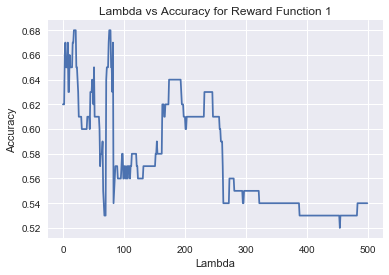

In [10]:

plt.plot(x_plot);
plt.title("Lambda vs Accuracy for Reward Function 1")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.show()

<h2> Question 12 </h2>

In [11]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)

max accuracy is:
0.68
best lambda is:
0.18


<h2> Question 13 </h2>


Heat Map - Reward Function 1


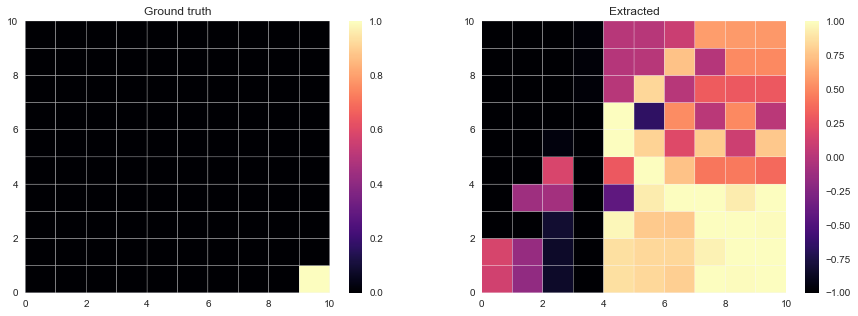

0.68


In [12]:
Rmax=1

# x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, 0.09)
# current_reward=x['x'][:state_num]
# current_reward=np.reshape(current_reward,(10,10))
# current_reward=np.transpose(current_reward)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(current_reward))


print("\nHeat Map - Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_1), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(max_reward), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()

policy_computed = val_iteration_fn(max_reward, state_space, action_set, discount)
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

<h2> Question 14 </h2>

Heat map of Optimal State Values for Reward Function 1


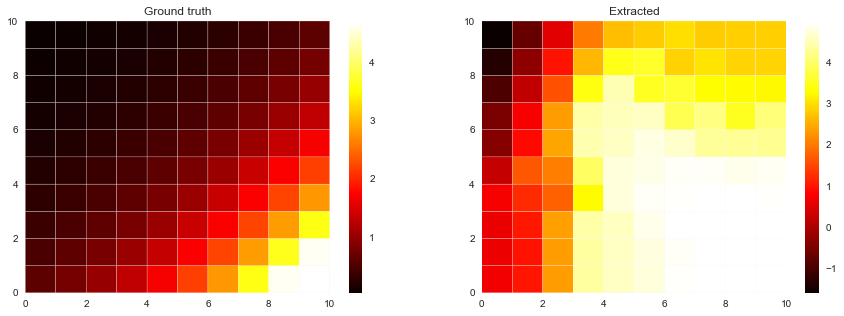

In [13]:
actual_value = value_iteration_value(reward_1, state_space, action_set, discount)
policy_value = value_iteration_value(max_reward, state_space, action_set, discount)

print("Heat map of Optimal State Values for Reward Function 1")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(actual_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
#optimal_state_values_extracted_r1 = get_optimal_state_value_fn(extracted_reward_fn_1, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(policy_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()

<h2> Question 16 </h2>

In [14]:
print("Optimal policy - Ground truth vs Extracted - Reward Function 1")


from matplotlib.colors import ListedColormap

import sys
arrows = [u'\u2191', u'\u2190',u'\u2193',u'\u2192']
arrow_matrix = np.array(policy_computed, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(policy_computed[i][j])
        arrow_matrix[i][j] = arrows[index]

        

arrow1_matrix = np.array(actual_policy, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(actual_policy[i][j])
        arrow1_matrix[i][j] = arrows[index]
        

multi_table([pd.DataFrame(arrow1_matrix), pd.DataFrame(arrow_matrix)])

Optimal policy - Ground truth vs Extracted - Reward Function 1


,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,→,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,→,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,→,↓,↓,↓
7,↓,→,→,→,→,→,→,→,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


In [15]:
x_plot=[]
reward_2 = np.zeros(shape=[10,10])
reward_2[1, 4:7] = -100
reward_2[1:7, 4] = -100
reward_2[1:4, 6] = -100
reward_2[3, 6:9] = -100
reward_2[3:8, 8] = -100
reward_2[7, 6:9] = -100
reward_2[8, 6] = -100
reward_2[9,9] = 10
actual_policy=val_iteration_fn(reward_2, state_space, action_set, discount)
optimum_policy=actual_policy
Rmax=10

In [16]:
max_accuracy=0
max_lambda=0
max_reward=[]
for i in range(0,500):
    x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, i/100.0)
    current_reward=x['x'][:state_num]
    current_reward=np.reshape(current_reward,(10,10))
    current_reward=np.transpose(current_reward)
    policy_computed = val_iteration_fn(current_reward, state_space, action_set, discount)
    count =0;
    for j in range(10):
        for k in range(10):
            if(policy_computed[j][k]==actual_policy[j][k]):
                count+=1;
    accuracy=count/100.0;
    if(accuracy>max_accuracy):
        max_accuracy=accuracy
        max_lambda=i/100.0
        max_reward=current_reward
    x_plot.append(accuracy);

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.2585e+00 -1.1221e+03  2e+03  9e-02  8e+00  8e-01
 2: -3.4423e+01 -6.8431e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.3348e+02 -4.7421e+02  8e+02  3e-02  2e+00  6e-01
 4: -2.6412e+02 -5.5468e+02  9e+02  2e-02  2e+00  6e-01
 5: -3.3301e+02 -5.6734e+02  9e+02  2e-02  2e+00  6e-01
 6: -4.3662e+02 -5.6416e+02  6e+02  1e-02  9e-01  4e-01
 7: -4.5898e+02 -5.4369e+02  4e+02  7e-03  6e-01  3e-01
 8: -5.0518e+02 -5.4344e+02  2e+02  3e-03  3e-01  2e-01
 9: -5.2242e+02 -5.4582e+02  1e+02  2e-03  2e-01  1e-01
10: -5.3535e+02 -5.4714e+02  6e+01  9e-04  8e-02  6e-02
11: -5.4424e+02 -5.4961e+02  3e+01  4e-04  4e-02  3e-02
12: -5.5033e+02 -5.5154e+02  6e+00  1e-04  9e-03  6e-03
13: -5.5066e+02 -5.5159e+02  5e+00  8e-05  7e-03  5e-03
14: -5.5129e+02 -5.5174e+02  2e+00  4e-05  3e-03  2e-03
15: -5.5182e+02 -5.5188e+02  3e-01  5e-06  4e-04  3e-04
16: -5.5188e+02 -5.5190e+02  8e-02  1e-06  1e-04  

15: -5.0247e+02 -5.0275e+02  1e+00  2e-05  2e-03  1e-03
16: -5.0280e+02 -5.0286e+02  2e-01  5e-06  4e-04  2e-04
17: -5.0287e+02 -5.0288e+02  5e-02  9e-07  8e-05  5e-05
18: -5.0288e+02 -5.0288e+02  7e-03  1e-07  1e-05  7e-06
19: -5.0288e+02 -5.0288e+02  2e-04  3e-09  3e-07  2e-07
20: -5.0288e+02 -5.0288e+02  2e-06  3e-11  3e-09  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  9.7337e+00 -1.0915e+03  2e+03  9e-02  8e+00  8e-01
 2: -2.1860e+01 -6.5417e+02  1e+03  5e-02  5e+00  7e-01
 3: -1.0568e+02 -4.2620e+02  7e+02  3e-02  2e+00  5e-01
 4: -2.3676e+02 -5.0151e+02  8e+02  2e-02  2e+00  6e-01
 5: -3.0316e+02 -5.0262e+02  7e+02  2e-02  1e+00  5e-01
 6: -3.9234e+02 -5.0413e+02  4e+02  9e-03  8e-01  3e-01
 7: -4.0538e+02 -4.8571e+02  3e+02  6e-03  6e-01  3e-01
 8: -4.6205e+02 -4.8888e+02  1e+02  2e-03  2e-01  9e-02
 9: -4.7719e+02 -4.9123e+02  6e+01  1e-03  1e-01  5e-02
10: -4.8059e+02 -4.9103e+0

11: -4.4512e+02 -4.4979e+02  2e+01  4e-04  3e-02  2e-02
12: -4.4816e+02 -4.5050e+02  1e+01  2e-04  2e-02  9e-03
13: -4.4950e+02 -4.5067e+02  5e+00  9e-05  8e-03  5e-03
14: -4.5050e+02 -4.5104e+02  2e+00  4e-05  4e-03  2e-03
15: -4.5102e+02 -4.5120e+02  7e-01  1e-05  1e-03  7e-04
16: -4.5115e+02 -4.5124e+02  4e-01  7e-06  6e-04  4e-04
17: -4.5126e+02 -4.5128e+02  6e-02  1e-06  1e-04  6e-05
18: -4.5128e+02 -4.5128e+02  5e-03  9e-08  8e-06  5e-06
19: -4.5128e+02 -4.5128e+02  5e-05  1e-09  9e-08  5e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  1.5734e+01 -1.0616e+03  2e+03  9e-02  8e+00  7e-01
 2: -1.0692e+01 -6.3222e+02  1e+03  5e-02  4e+00  6e-01
 3: -8.1733e+01 -3.8380e+02  6e+02  2e-02  2e+00  5e-01
 4: -1.7849e+02 -4.4334e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.5409e+02 -4.5352e+02  6e+02  2e-02  1e+00  5e-01
 6: -3.2074e+02 -4.5355e+02  5e+02  1e-02  9e-01  4e-01
 7: -3.5775e+02 -4.4663e+0

10: -3.9564e+02 -4.0241e+02  3e+01  5e-04  5e-02  2e-02
11: -3.9868e+02 -4.0267e+02  2e+01  3e-04  3e-02  1e-02
12: -4.0117e+02 -4.0289e+02  7e+00  1e-04  1e-02  7e-03
13: -4.0288e+02 -4.0335e+02  2e+00  4e-05  3e-03  2e-03
14: -4.0307e+02 -4.0340e+02  1e+00  3e-05  2e-03  1e-03
15: -4.0341e+02 -4.0348e+02  3e-01  6e-06  5e-04  3e-04
16: -4.0349e+02 -4.0350e+02  3e-02  6e-07  6e-05  3e-05
17: -4.0350e+02 -4.0351e+02  4e-03  8e-08  7e-06  4e-06
18: -4.0351e+02 -4.0351e+02  4e-05  9e-10  8e-08  4e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.1303e+01 -1.0325e+03  2e+03  8e-02  7e+00  7e-01
 2: -1.0858e+00 -6.1066e+02  1e+03  5e-02  4e+00  6e-01
 3: -6.2957e+01 -3.4442e+02  6e+02  2e-02  2e+00  4e-01
 4: -1.4501e+02 -3.9810e+02  7e+02  2e-02  2e+00  5e-01
 5: -2.1292e+02 -4.1257e+02  6e+02  2e-02  1e+00  5e-01
 6: -2.7473e+02 -4.0733e+02  5e+02  1e-02  9e-01  3e-01
 7: -3.0409e+02 -4.0295e+0

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  2.6251e+01 -1.0197e+03  2e+03  8e-02  7e+00  7e-01
 2:  7.6757e+00 -5.9881e+02  1e+03  5e-02  4e+00  6e-01
 3: -4.5806e+01 -3.0998e+02  5e+02  2e-02  2e+00  4e-01
 4: -1.1804e+02 -3.5858e+02  6e+02  2e-02  2e+00  5e-01
 5: -1.7360e+02 -3.7349e+02  6e+02  2e-02  1e+00  5e-01
 6: -2.2923e+02 -3.6544e+02  5e+02  1e-02  9e-01  3e-01
 7: -2.7925e+02 -3.5918e+02  3e+02  6e-03  6e-01  2e-01
 8: -3.0130e+02 -3.4877e+02  2e+02  4e-03  3e-01  2e-01
 9: -3.3241e+02 -3.5106e+02  7e+01  1e-03  1e-01  6e-02
10: -3.4495e+02 -3.5142e+02  3e+01  5e-04  4e-02  2e-02
11: -3.4946e+02 -3.5197e+02  1e+01  2e-04  2e-02  9e-03
12: -3.5187e+02 -3.5243e+02  2e+00  5e-05  4e-03  2e-03
13: -3.5201e+02 -3.5245e+02  2e+00  3e-05  3e-03  2e-03
14: -3.5242e+02 -3.5254e+02  5e-01  9e-06  8e-04  4e-04
15: -3.5254e+02 -3.5256e+02  9e-02  2e-06  2e-04  9e-05
16: -3.5256e+02 -3.5256e+02  3e-02  5e-07  4e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.1219e+01 -1.0150e+03  2e+03  8e-02  7e+00  7e-01
 2:  1.6369e+01 -5.9178e+02  1e+03  5e-02  4e+00  6e-01
 3: -2.9234e+01 -2.7813e+02  4e+02  2e-02  2e+00  3e-01
 4: -9.4014e+01 -3.1780e+02  5e+02  2e-02  2e+00  4e-01
 5: -1.3455e+02 -3.2958e+02  6e+02  2e-02  1e+00  4e-01
 6: -1.7738e+02 -3.2331e+02  5e+02  1e-02  1e+00  3e-01
 7: -2.2404e+02 -3.1163e+02  3e+02  7e-03  6e-01  2e-01
 8: -2.4201e+02 -3.0546e+02  2e+02  5e-03  4e-01  2e-01
 9: -2.7657e+02 -3.0293e+02  1e+02  2e-03  2e-01  8e-02
10: -2.9051e+02 -3.0297e+02  5e+01  1e-03  8e-02  4e-02
11: -2.9862e+02 -3.0314e+02  2e+01  4e-04  3e-02  2e-02
12: -3.0188e+02 -3.0345e+02  6e+00  1e-04  1e-02  6e-03
13: -3.0301e+02 -3.0354e+02  2e+00  4e-05  4e-03  2e-03
14: -3.0343e+02 -3.0359e+02  7e-01  1e-05  1e-03  7e-04
15: -3.0360e+02 -3.0363e+02  1e-01  2e-06  2e-04  1e-04
16: -3.0363e+02 -3.0363e+02  1e-02  2e-07  2e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.5656e+01 -1.0102e+03  2e+03  8e-02  7e+00  7e-01
 2:  2.3693e+01 -5.8500e+02  1e+03  5e-02  4e+00  6e-01
 3: -1.6031e+01 -2.5481e+02  4e+02  2e-02  2e+00  3e-01
 4: -7.5850e+01 -2.7682e+02  5e+02  2e-02  1e+00  4e-01
 5: -1.0311e+02 -2.8435e+02  5e+02  1e-02  1e+00  4e-01
 6: -1.5323e+02 -2.7814e+02  4e+02  1e-02  8e-01  3e-01
 7: -1.8018e+02 -2.6312e+02  3e+02  7e-03  5e-01  2e-01
 8: -2.0597e+02 -2.5836e+02  2e+02  4e-03  3e-01  2e-01
 9: -2.3351e+02 -2.5343e+02  8e+01  2e-03  1e-01  7e-02
10: -2.4857e+02 -2.5479e+02  2e+01  5e-04  4e-02  2e-02
11: -2.5340e+02 -2.5543e+02  8e+00  2e-04  1e-02  7e-03
12: -2.5484e+02 -2.5564e+02  3e+00  6e-05  5e-03  3e-03
13: -2.5552e+02 -2.5574e+02  9e-01  2e-05  1e-03  8e-04
14: -2.5575e+02 -2.5578e+02  1e-01  2e-06  2e-04  1e-04
15: -2.5578e+02 -2.5578e+02  1e-02  2e-07  2e-05  1e-05
16: -2.5578e+02 -2.5578e+02  1e-04  3e-09  2e-07  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  3.9585e+01 -1.0074e+03  2e+03  8e-02  7e+00  7e-01
 2:  2.9941e+01 -5.7952e+02  9e+02  5e-02  4e+00  6e-01
 3: -5.4826e+00 -2.3824e+02  4e+02  2e-02  1e+00  3e-01
 4: -6.2790e+01 -2.2753e+02  4e+02  1e-02  1e+00  3e-01
 5: -7.9726e+01 -2.3272e+02  4e+02  1e-02  1e+00  3e-01
 6: -1.1751e+02 -2.3348e+02  4e+02  9e-03  7e-01  3e-01
 7: -1.3766e+02 -2.1596e+02  3e+02  6e-03  5e-01  2e-01
 8: -1.6545e+02 -2.1475e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.8055e+02 -2.1212e+02  1e+02  3e-03  2e-01  9e-02
10: -2.0162e+02 -2.1165e+02  4e+01  8e-04  6e-02  3e-02
11: -2.0739e+02 -2.1145e+02  2e+01  3e-04  3e-02  1e-02
12: -2.0999e+02 -2.1152e+02  6e+00  1e-04  1e-02  5e-03
13: -2.1086e+02 -2.1159e+02  3e+00  6e-05  5e-03  3e-03
14: -2.1150e+02 -2.1163e+02  5e-01  1e-05  8e-04  5e-04
15: -2.1161e+02 -2.1164e+02  1e-01  2e-06  2e-04  1e-04
16: -2.1164e+02 -2.1165e+02  9e-03  2e-07  1e-05  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.3087e+01 -1.0051e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.5303e+01 -5.7432e+02  9e+02  5e-02  4e+00  6e-01
 3:  3.6269e+00 -2.3468e+02  4e+02  2e-02  1e+00  3e-01
 4: -2.6025e+01 -1.9693e+02  3e+02  1e-02  1e+00  3e-01
 5: -6.5972e+01 -1.9496e+02  3e+02  1e-02  8e-01  2e-01
 6: -8.2078e+01 -1.9891e+02  4e+02  9e-03  7e-01  3e-01
 7: -9.2403e+01 -1.8237e+02  3e+02  7e-03  6e-01  2e-01
 8: -1.2138e+02 -1.6986e+02  2e+02  4e-03  3e-01  1e-01
 9: -1.4269e+02 -1.6946e+02  1e+02  2e-03  2e-01  8e-02
10: -1.5594e+02 -1.6953e+02  5e+01  1e-03  8e-02  4e-02
11: -1.6345e+02 -1.6941e+02  2e+01  5e-04  4e-02  2e-02
12: -1.6835e+02 -1.6999e+02  6e+00  1e-04  1e-02  6e-03
13: -1.6939e+02 -1.7011e+02  3e+00  6e-05  4e-03  3e-03
14: -1.6991e+02 -1.7018e+02  1e+00  2e-05  2e-03  1e-03
15: -1.7013e+02 -1.7021e+02  3e-01  6e-06  4e-04  3e-04
16: -1.7019e+02 -1.7021e+02  8e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.5839e+01 -1.0033e+03  2e+03  8e-02  6e+00  7e-01
 2:  3.9390e+01 -5.6994e+02  9e+02  5e-02  4e+00  6e-01
 3:  9.6104e+00 -2.2912e+02  4e+02  2e-02  1e+00  3e-01
 4: -8.7404e+00 -1.7742e+02  3e+02  1e-02  1e+00  2e-01
 5: -4.9091e+01 -1.5870e+02  3e+02  9e-03  7e-01  2e-01
 6: -5.0720e+01 -1.5774e+02  3e+02  9e-03  6e-01  2e-01
 7: -7.5967e+01 -1.5473e+02  2e+02  6e-03  5e-01  2e-01
 8: -8.5678e+01 -1.4546e+02  2e+02  5e-03  4e-01  1e-01
 9: -1.0070e+02 -1.3574e+02  1e+02  3e-03  2e-01  1e-01
10: -1.1749e+02 -1.3501e+02  6e+01  1e-03  1e-01  5e-02
11: -1.2131e+02 -1.3458e+02  5e+01  1e-03  8e-02  4e-02
12: -1.3113e+02 -1.3522e+02  1e+01  3e-04  2e-02  1e-02
13: -1.3319e+02 -1.3554e+02  8e+00  2e-04  1e-02  8e-03
14: -1.3449e+02 -1.3568e+02  4e+00  1e-04  7e-03  4e-03
15: -1.3546e+02 -1.3580e+02  1e+00  3e-05  2e-03  1e-03
16: -1.3566e+02 -1.3582e+02  6e-01  1e-05  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  4.7990e+01 -1.0019e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.2510e+01 -5.6628e+02  9e+02  5e-02  4e+00  6e-01
 3:  1.3674e+01 -2.2284e+02  4e+02  2e-02  1e+00  2e-01
 4: -1.0917e-01 -1.6008e+02  3e+02  1e-02  9e-01  2e-01
 5: -3.4603e+01 -1.2360e+02  2e+02  7e-03  5e-01  2e-01
 6: -4.1633e+01 -1.2293e+02  2e+02  7e-03  5e-01  2e-01
 7: -5.2834e+01 -1.2539e+02  2e+02  6e-03  4e-01  2e-01
 8: -7.4278e+01 -1.1770e+02  1e+02  3e-03  3e-01  1e-01
 9: -8.9750e+01 -1.1087e+02  7e+01  2e-03  1e-01  5e-02
10: -9.5460e+01 -1.0773e+02  4e+01  1e-03  7e-02  4e-02
11: -1.0208e+02 -1.0697e+02  2e+01  4e-04  3e-02  2e-02
12: -1.0485e+02 -1.0721e+02  8e+00  2e-04  1e-02  8e-03
13: -1.0663e+02 -1.0736e+02  2e+00  6e-05  4e-03  2e-03
14: -1.0720e+02 -1.0738e+02  6e-01  1e-05  1e-03  6e-04
15: -1.0731e+02 -1.0739e+02  3e-01  6e-06  5e-04  3e-04
16: -1.0737e+02 -1.0739e+02  6e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.0277e+01 -1.0006e+03  2e+03  8e-02  6e+00  7e-01
 2:  4.6183e+01 -5.6513e+02  9e+02  5e-02  3e+00  6e-01
 3:  1.8078e+01 -2.1469e+02  3e+02  2e-02  1e+00  2e-01
 4:  6.1208e+00 -1.3620e+02  2e+02  1e-02  8e-01  2e-01
 5: -1.4599e+01 -9.7972e+01  2e+02  7e-03  5e-01  1e-01
 6: -3.0475e+01 -1.0202e+02  2e+02  6e-03  4e-01  1e-01
 7: -3.2824e+01 -9.7997e+01  2e+02  5e-03  4e-01  1e-01
 8: -4.5638e+01 -9.0392e+01  1e+02  4e-03  3e-01  1e-01
 9: -5.7229e+01 -8.5536e+01  8e+01  2e-03  2e-01  7e-02
10: -6.5227e+01 -8.1481e+01  5e+01  1e-03  9e-02  4e-02
11: -7.2137e+01 -7.9212e+01  2e+01  6e-04  4e-02  2e-02
12: -7.4730e+01 -7.8636e+01  1e+01  3e-04  2e-02  1e-02
13: -7.7076e+01 -7.8285e+01  4e+00  1e-04  7e-03  4e-03
14: -7.7859e+01 -7.8225e+01  1e+00  3e-05  2e-03  1e-03
15: -7.8086e+01 -7.8209e+01  4e-01  1e-05  7e-04  4e-04
16: -7.8164e+01 -7.8204e+01  1e-01  3e-06  2e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  2e+01  1e+00
 1:  5.2348e+01 -9.9944e+02  2e+03  8e-02  6e+00  7e-01
 2:  4.9890e+01 -5.6649e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.1771e+01 -2.0555e+02  3e+02  2e-02  1e+00  2e-01
 4:  9.9448e+00 -1.0979e+02  2e+02  1e-02  6e-01  1e-01
 5: -2.0785e+00 -7.6933e+01  1e+02  6e-03  4e-01  1e-01
 6: -1.6183e+01 -7.5895e+01  1e+02  5e-03  3e-01  1e-01
 7: -1.5532e+01 -7.0876e+01  1e+02  4e-03  3e-01  1e-01
 8: -1.9949e+01 -6.7014e+01  1e+02  4e-03  3e-01  1e-01
 9: -3.3838e+01 -6.0287e+01  7e+01  2e-03  1e-01  6e-02
10: -4.1156e+01 -5.5281e+01  4e+01  1e-03  8e-02  3e-02
11: -4.8402e+01 -5.2905e+01  1e+01  4e-04  2e-02  1e-02
12: -4.9715e+01 -5.2462e+01  8e+00  2e-04  1e-02  7e-03
13: -5.1418e+01 -5.2149e+01  2e+00  6e-05  4e-03  2e-03
14: -5.1813e+01 -5.2076e+01  8e-01  2e-05  1e-03  7e-04
15: -5.1966e+01 -5.2056e+01  3e-01  7e-06  5e-04  3e-04
16: -5.2026e+01 -5.2048e+01  7e-02  2e-06  1e-04  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.4224e+01 -9.9845e+02  2e+03  8e-02  6e+00  7e-01
 2:  5.3313e+01 -5.6763e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.5022e+01 -1.9529e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.2584e+01 -8.2311e+01  1e+02  8e-03  5e-01  1e-01
 5:  5.8398e+00 -5.6434e+01  1e+02  5e-03  3e-01  9e-02
 6: -7.2925e+00 -4.0085e+01  7e+01  3e-03  2e-01  7e-02
 7: -7.3942e+00 -3.9044e+01  7e+01  3e-03  2e-01  7e-02
 8: -1.1417e+01 -3.7880e+01  6e+01  2e-03  1e-01  6e-02
 9: -1.4070e+01 -3.5530e+01  5e+01  2e-03  1e-01  5e-02
10: -1.9534e+01 -3.3707e+01  4e+01  1e-03  7e-02  3e-02
11: -2.0227e+01 -3.2765e+01  3e+01  1e-03  7e-02  3e-02
12: -2.5279e+01 -3.0873e+01  1e+01  4e-04  3e-02  1e-02
13: -2.6242e+01 -3.0289e+01  1e+01  3e-04  2e-02  1e-02
14: -2.6710e+01 -3.0118e+01  9e+00  3e-04  2e-02  9e-03
15: -2.8878e+01 -2.9625e+01  2e+00  6e-05  4e-03  2e-03
16: -2.9255e+01 -2.9518e+01  7e-01  2e-05  1e-03  

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.5921e+01 -9.9762e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.6485e+01 -5.6858e+02  9e+02  5e-02  3e+00  6e-01
 3:  2.8243e+01 -1.8417e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.3722e+01 -5.3858e+01  1e+02  5e-03  3e-01  9e-02
 5:  9.7103e+00 -3.4096e+01  7e+01  4e-03  2e-01  7e-02
 6:  2.6833e+00 -1.7745e+01  4e+01  2e-03  1e-01  4e-02
 7: -1.3832e+00 -1.7106e+01  4e+01  1e-03  8e-02  3e-02
 8: -1.1988e+00 -1.6133e+01  3e+01  1e-03  8e-02  3e-02
 9: -3.3804e+00 -1.4510e+01  2e+01  9e-04  6e-02  2e-02
10: -3.9604e+00 -1.3928e+01  2e+01  8e-04  5e-02  2e-02
11: -4.2135e+00 -1.2737e+01  2e+01  7e-04  4e-02  2e-02
12: -5.4788e+00 -1.2030e+01  2e+01  5e-04  3e-02  1e-02
13: -6.0321e+00 -1.1512e+01  1e+01  4e-04  3e-02  1e-02
14: -7.7333e+00 -1.0890e+01  8e+00  3e-04  2e-02  7e-03
15: -7.7412e+00 -1.0882e+01  8e+00  3e-04  2e-02  7e-03
16: -8.8300e+00 -1.0346e+01  4e+00  1e-04  8e-03  

 1:  5.7457e+01 -9.9692e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.9432e+01 -5.6933e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.1045e+01 -1.7197e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.5580e+01 -4.5248e+01  9e+01  5e-03  3e-01  8e-02
 5:  9.8306e+00 -2.1161e+01  4e+01  2e-03  2e-01  4e-02
 6:  3.3353e+00 -3.8945e+00  1e+01  6e-04  4e-02  1e-02
 7:  9.7774e-01 -6.5072e-01  2e+00  1e-04  8e-03  2e-03
 8:  3.5625e-01 -1.3323e-01  6e-01  4e-05  2e-03  6e-04
 9:  7.6392e-03 -2.4769e-03  1e-02  8e-07  5e-05  1e-05
10:  7.6336e-05 -2.4748e-05  1e-04  8e-09  5e-07  1e-07
11:  7.6335e-07 -2.4748e-07  1e-06  8e-11  5e-09  1e-09
12:  7.6335e-09 -2.4748e-09  1e-08  8e-13  6e-11  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.7664e+01 -9.9683e+02  2e+03  8e-02  5e+00  7e-01
 2:  5.9837e+01 -5.6942e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.1414e+01 -1.7015e+02  3e+02  2e-02  1e+00  2e-01
 4:  1.5859e+01 -4.4944e+0

 5:  5.7943e+00 -7.4860e+00  2e+01  1e-03  6e-02  1e-02
 6:  6.8269e-01 -1.5186e-01  9e-01  7e-05  4e-03  9e-04
 7:  7.2318e-03 -1.6079e-03  1e-02  7e-07  4e-05  1e-05
 8:  7.2307e-05 -1.6076e-05  1e-04  7e-09  4e-07  1e-07
 9:  7.2307e-07 -1.6076e-07  1e-06  7e-11  4e-09  1e-09
10:  7.2307e-09 -1.6076e-09  1e-08  7e-13  4e-11  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  5.9930e+01 -9.9594e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.4387e+01 -5.7028e+02  9e+02  5e-02  3e+00  6e-01
 3:  3.6058e+01 -1.5763e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.7469e+01 -4.0012e+01  8e+01  5e-03  3e-01  7e-02
 5:  5.5918e+00 -6.9679e+00  2e+01  1e-03  6e-02  1e-02
 6:  5.7220e-01 -1.2773e-01  8e-01  6e-05  3e-03  8e-04
 7:  5.9178e-03 -1.3206e-03  8e-03  6e-07  3e-05  8e-06
 8:  5.9171e-05 -1.3204e-05  8e-05  6e-09  3e-07  8e-08
 9:  5.9171e-07 -1.3204e-07  8e-07  6e-11  3e-09  8e-10
10:  5.9171e-09 -1.3204e-0

 5:  3.3351e+00 -2.9113e+00  7e+00  5e-04  3e-02  6e-03
 6:  7.1322e-02 -3.0521e-02  1e-01  8e-06  4e-04  1e-04
 7:  7.1276e-04 -3.0500e-04  1e-03  8e-08  4e-06  1e-06
 8:  7.1276e-06 -3.0500e-06  1e-05  8e-10  4e-08  1e-08
 9:  7.1276e-08 -3.0500e-08  1e-07  8e-12  4e-10  1e-10
10:  7.1276e-10 -3.0500e-10  1e-09  8e-14  5e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.1832e+01 -9.9532e+02  2e+03  8e-02  5e+00  7e-01
 2:  6.8447e+01 -5.7067e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.0752e+01 -1.5668e+02  3e+02  2e-02  9e-01  2e-01
 4:  1.6454e+01 -3.1054e+01  6e+01  4e-03  2e-01  5e-02
 5:  3.1603e+00 -2.7043e+00  7e+00  5e-04  3e-02  6e-03
 6:  6.0179e-02 -2.8035e-02  1e-01  7e-06  4e-04  9e-05
 7:  6.0145e-04 -2.8019e-04  1e-03  7e-08  4e-06  9e-07
 8:  6.0144e-06 -2.8018e-06  1e-05  7e-10  4e-08  9e-09
 9:  6.0144e-08 -2.8018e-08  1e-07  7e-12  4e-10  9e-11
Optimal solution found.
  

 4:  1.5688e+01 -2.3591e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.7129e+00 -1.0418e+00  3e+00  2e-04  1e-02  3e-03
 6:  1.7976e-02 -1.0595e-02  3e-02  2e-06  1e-04  3e-05
 7:  1.7973e-04 -1.0593e-04  3e-04  2e-08  1e-06  3e-07
 8:  1.7973e-06 -1.0593e-06  3e-06  2e-10  1e-08  3e-09
 9:  1.7973e-08 -1.0593e-08  3e-08  2e-12  1e-10  3e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.3544e+01 -9.9490e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.2380e+01 -5.7061e+02  1e+03  5e-02  3e+00  6e-01
 3:  4.5106e+01 -1.5503e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.5656e+01 -2.3121e+01  5e+01  3e-03  2e-01  4e-02
 5:  1.6280e+00 -9.6747e-01  3e+00  2e-04  1e-02  2e-03
 6:  1.6925e-02 -9.8247e-03  3e-02  2e-06  1e-04  3e-05
 7:  1.6923e-04 -9.8231e-05  3e-04  2e-08  1e-06  3e-07
 8:  1.6923e-06 -9.8231e-07  3e-06  2e-10  1e-08  3e-09
 9:  1.6923e-08 -9.8231e-09  3e-08  2e-12  1e-10  3e-11
Optimal solution found.
  

 3:  4.8584e+01 -1.5306e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4930e+01 -1.7777e+01  4e+01  3e-03  1e-01  4e-02
 5:  8.5149e-01 -4.1908e-01  1e+00  1e-04  5e-03  1e-03
 6:  8.5247e-03 -4.1940e-03  1e-02  1e-06  5e-05  1e-05
 7:  8.5242e-05 -4.1937e-05  1e-04  1e-08  5e-07  1e-07
 8:  8.5242e-07 -4.1937e-07  1e-06  1e-10  5e-09  1e-09
 9:  8.5242e-09 -4.1937e-09  1e-08  1e-12  5e-11  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.4948e+01 -9.9469e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.5903e+01 -5.7009e+02  1e+03  5e-02  2e+00  6e-01
 3:  4.8854e+01 -1.5288e+02  3e+02  2e-02  8e-01  2e-01
 4:  1.4846e+01 -1.7360e+01  4e+01  3e-03  1e-01  3e-02
 5:  8.0487e-01 -3.9327e-01  1e+00  1e-04  5e-03  1e-03
 6:  8.0532e-03 -3.9339e-03  1e-02  1e-06  5e-05  1e-05
 7:  8.0527e-05 -3.9336e-05  1e-04  1e-08  5e-07  1e-07
 8:  8.0527e-07 -3.9336e-07  1e-06  1e-10  5e-09  1e-09
 9:  8.0527e-09 -3.9336e-0

 4:  1.3636e+01 -1.2751e+01  3e+01  2e-03  1e-01  3e-02
 5:  4.1187e-01 -1.7996e-01  7e-01  5e-05  2e-03  6e-04
 6:  4.1131e-03 -1.7972e-03  7e-03  5e-07  2e-05  6e-06
 7:  4.1130e-05 -1.7971e-05  7e-05  5e-09  2e-07  6e-08
 8:  4.1130e-07 -1.7971e-07  7e-07  5e-11  2e-09  6e-10
 9:  4.1130e-09 -1.7971e-09  7e-09  5e-13  2e-11  6e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.6090e+01 -9.9465e+02  2e+03  8e-02  4e+00  7e-01
 2:  7.9078e+01 -5.6914e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.2115e+01 -1.5035e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.3522e+01 -1.2401e+01  3e+01  2e-03  9e-02  3e-02
 5:  3.9014e-01 -1.6993e-01  6e-01  4e-05  2e-03  6e-04
 6:  3.8961e-03 -1.6970e-03  6e-03  4e-07  2e-05  6e-06
 7:  3.8961e-05 -1.6970e-05  6e-05  4e-09  2e-07  6e-08
 8:  3.8961e-07 -1.6970e-07  6e-07  4e-11  2e-09  6e-10
 9:  3.8961e-09 -1.6970e-09  6e-09  4e-13  2e-11  6e-12
Optimal solution found.
  

 5:  2.6367e-01 -1.2583e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.6344e-03 -1.2572e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.6343e-05 -1.2572e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.6343e-07 -1.2572e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.6343e-09 -1.2572e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  1e+01  1e+00
 1:  6.7011e+01 -9.9472e+02  2e+03  8e-02  4e+00  7e-01
 2:  8.1957e+01 -5.6778e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.4977e+01 -1.4754e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.2543e+01 -1.0297e+01  3e+01  2e-03  8e-02  2e-02
 5:  2.5916e-01 -1.2502e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.5893e-03 -1.2491e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.5892e-05 -1.2491e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.5892e-07 -1.2491e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.5892e-09 -1.2491e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: 

 7:  2.1011e-05 -1.1549e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.1011e-07 -1.1549e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.1011e-09 -1.1549e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7741e+01 -9.9489e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.4582e+01 -5.6604e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.7505e+01 -1.4450e+02  3e+02  2e-02  7e-01  2e-01
 4:  1.1915e+01 -1.0004e+01  3e+01  2e-03  7e-02  2e-02
 5:  2.0665e-01 -1.1480e-01  4e-01  3e-05  1e-03  4e-04
 6:  2.0649e-03 -1.1472e-03  4e-03  3e-07  1e-05  4e-06
 7:  2.0649e-05 -1.1472e-05  4e-05  3e-09  1e-07  4e-08
 8:  2.0649e-07 -1.1472e-07  4e-07  3e-11  1e-09  4e-10
 9:  2.0649e-09 -1.1472e-09  4e-09  3e-13  1e-11  4e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.7791e+01 -9.9491e+02  2e+03  9e-02  3e+00  7e-01
 2: 

 7:  1.6842e-05 -1.0551e-05  3e-05  2e-09  8e-08  3e-08
 8:  1.6842e-07 -1.0551e-07  3e-07  2e-11  8e-10  3e-10
 9:  1.6842e-09 -1.0551e-09  3e-09  2e-13  9e-12  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.8311e+01 -9.9512e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.6988e+01 -5.6396e+02  1e+03  5e-02  2e+00  6e-01
 3:  5.9749e+01 -1.4128e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.1128e+01 -9.4913e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.6577e-01 -1.0481e-01  3e-01  2e-05  8e-04  3e-04
 6:  1.6568e-03 -1.0475e-03  3e-03  2e-07  8e-06  3e-06
 7:  1.6568e-05 -1.0475e-05  3e-05  2e-09  8e-08  3e-08
 8:  1.6568e-07 -1.0475e-07  3e-07  2e-11  8e-10  3e-10
 9:  1.6568e-09 -1.0475e-09  3e-09  2e-13  8e-12  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  9e+00  1e+00
 1:  6.8349e+01 -9.9514e+02  2e+03  9e-02  3e+00  7e-01
 2: 

 3:  6.1748e+01 -1.3790e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0261e+01 -8.8623e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.3517e-01 -9.5109e-02  3e-01  2e-05  7e-04  2e-04
 6:  1.3511e-03 -9.5067e-04  3e-03  2e-07  7e-06  2e-06
 7:  1.3511e-05 -9.5067e-06  3e-05  2e-09  7e-08  2e-08
 8:  1.3511e-07 -9.5067e-08  3e-07  2e-11  7e-10  2e-10
 9:  1.3511e-09 -9.5067e-10  3e-09  2e-13  7e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.8770e+01 -9.9542e+02  2e+03  9e-02  3e+00  7e-01
 2:  8.9367e+01 -5.6134e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.1893e+01 -1.3764e+02  3e+02  2e-02  6e-01  2e-01
 4:  1.0193e+01 -8.8109e+00  2e+01  2e-03  6e-02  2e-02
 5:  1.3317e-01 -9.4380e-02  3e-01  2e-05  7e-04  2e-04
 6:  1.3312e-03 -9.4339e-04  3e-03  2e-07  7e-06  2e-06
 7:  1.3312e-05 -9.4339e-06  3e-05  2e-09  7e-08  2e-08
 8:  1.3312e-07 -9.4339e-08  3e-07  2e-11  7e-10  2e-10
 9:  1.3312e-09 -9.4339e-1

 7:  1.1238e-05 -8.5804e-06  2e-05  2e-09  6e-08  2e-08
 8:  1.1238e-07 -8.5804e-08  2e-07  2e-11  6e-10  2e-10
 9:  1.1238e-09 -8.5804e-10  2e-09  2e-13  6e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9075e+01 -9.9572e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.1408e+01 -5.5860e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.3660e+01 -1.3410e+02  3e+02  2e-02  5e-01  3e-01
 4:  9.2979e+00 -8.1184e+00  2e+01  1e-03  5e-02  2e-02
 5:  1.1093e-01 -8.5139e-02  2e-01  2e-05  5e-04  2e-04
 6:  1.1089e-03 -8.5110e-04  2e-03  2e-07  5e-06  2e-06
 7:  1.1089e-05 -8.5110e-06  2e-05  2e-09  5e-08  2e-08
 8:  1.1089e-07 -8.5110e-08  2e-07  2e-11  5e-10  2e-10
 9:  1.1089e-09 -8.5110e-10  2e-09  2e-13  5e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  4e+03  2e-01  8e+00  1e+00
 1:  6.9094e+01 -9.9575e+02  2e+03  9e-02  3e+00  7e-01
 2: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9280e+01 -9.9604e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.3306e+01 -5.5559e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.5236e+01 -1.3043e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.4096e+00 -7.3938e+00  2e+01  1e-03  4e-02  2e-02
 5:  9.4025e-02 -7.6312e-02  2e-01  1e-05  5e-04  2e-04
 6:  9.3999e-04 -7.6290e-04  2e-03  1e-07  5e-06  2e-06
 7:  9.3998e-06 -7.6290e-06  2e-05  1e-09  5e-08  2e-08
 8:  9.3998e-08 -7.6290e-08  2e-07  1e-11  5e-10  2e-10
 9:  9.3998e-10 -7.6290e-10  2e-09  1e-13  5e-12  2e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9292e+01 -9.9606e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.3446e+01 -5.5535e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.5350e+01 -1.3014e+02  3e+02  2e-02  5e-01  3e-01
 4:  8.3421e+00 -7.3371e+00  2e+01  1e-03  4e-02  2e-02
 5:  9.2891e-02 -7.5647e-02 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9399e+01 -9.9635e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.5078e+01 -5.5233e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6641e+01 -1.2663e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.2839e+00 -5.5321e+00  2e+01  1e-03  3e-02  1e-02
 5:  7.6818e-02 -5.6835e-02  2e-01  1e-05  3e-04  1e-04
 6:  7.6802e-04 -5.6823e-04  2e-03  1e-07  3e-06  1e-06
 7:  7.6801e-06 -5.6823e-06  2e-05  1e-09  3e-08  1e-08
 8:  7.6801e-08 -5.6823e-08  2e-07  1e-11  3e-10  1e-10
 9:  7.6801e-10 -5.6823e-10  2e-09  1e-13  3e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9405e+01 -9.9637e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.5210e+01 -5.5207e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.6742e+01 -1.2633e+02  3e+02  2e-02  5e-01  3e-01
 4:  7.1942e+00 -5.3846e+00  2e+01  1e-03  3e-02  1e-02
 5:  7.5649e-02 -5.5319e-02 

 3:  6.7889e+01 -1.2269e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.3902e+00 -4.2318e+00  1e+01  9e-04  3e-02  1e-02
 5:  6.5787e-02 -4.3359e-02  1e-01  9e-06  3e-04  1e-04
 6:  6.5776e-04 -4.3352e-04  1e-03  9e-08  3e-06  1e-06
 7:  6.5776e-06 -4.3352e-06  1e-05  9e-10  3e-08  1e-08
 8:  6.5776e-08 -4.3352e-08  1e-07  9e-12  3e-10  1e-10
 9:  6.5776e-10 -4.3352e-10  1e-09  9e-14  3e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  7e+00  1e+00
 1:  6.9446e+01 -9.9668e+02  2e+03  9e-02  3e+00  7e-01
 2:  9.6865e+01 -5.4857e+02  1e+03  5e-02  2e+00  6e-01
 3:  6.7979e+01 -1.2238e+02  3e+02  2e-02  5e-01  3e-01
 4:  6.3411e+00 -4.1751e+00  1e+01  8e-04  3e-02  1e-02
 5:  6.5221e-02 -4.2767e-02  1e-01  9e-06  3e-04  1e-04
 6:  6.5209e-04 -4.2760e-04  1e-03  9e-08  3e-06  1e-06
 7:  6.5209e-06 -4.2760e-06  1e-05  9e-10  3e-08  1e-08
 8:  6.5209e-08 -4.2760e-08  1e-07  9e-12  3e-10  1e-10
 9:  6.5209e-10 -4.2760e-1

 4:  5.7621e+00 -3.5262e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.8697e-02 -3.5969e-02  1e-01  8e-06  2e-04  1e-04
 6:  5.8689e-04 -3.5964e-04  1e-03  8e-08  2e-06  1e-06
 7:  5.8688e-06 -3.5964e-06  1e-05  8e-10  2e-08  1e-08
 8:  5.8688e-08 -3.5964e-08  1e-07  8e-12  2e-10  1e-10
 9:  5.8688e-10 -3.5964e-10  1e-09  8e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9421e+01 -9.9698e+02  2e+03  9e-02  2e+00  7e-01
 2:  9.8538e+01 -5.4458e+02  1e+03  5e-02  1e+00  6e-01
 3:  6.9243e+01 -1.1930e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.7254e+00 -3.4850e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.8292e-02 -3.5538e-02  1e-01  8e-06  2e-04  1e-04
 6:  5.8284e-04 -3.5533e-04  1e-03  8e-08  2e-06  1e-06
 7:  5.8284e-06 -3.5533e-06  1e-05  8e-10  2e-08  1e-08
 8:  5.8284e-08 -3.5533e-08  1e-07  8e-12  2e-10  1e-10
 9:  5.8284e-10 -3.5533e-10  1e-09  8e-14  2e-12  1e-12
Optimal solution found.
  

 4:  5.2745e+00 -2.9978e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.3384e-02 -3.0447e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.3377e-04 -3.0443e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.3377e-06 -3.0443e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.3377e-08 -3.0443e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.3377e-10 -3.0443e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9343e+01 -9.9724e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0000e+02 -5.4070e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.0406e+01 -1.1801e+02  3e+02  2e-02  4e-01  3e-01
 4:  5.2362e+00 -2.9582e+00  1e+01  7e-04  2e-02  1e-02
 5:  5.2974e-02 -3.0035e-02  1e-01  7e-06  2e-04  1e-04
 6:  5.2967e-04 -3.0031e-04  1e-03  7e-08  2e-06  1e-06
 7:  5.2967e-06 -3.0031e-06  1e-05  7e-10  2e-08  1e-08
 8:  5.2967e-08 -3.0031e-08  1e-07  7e-12  2e-10  1e-10
 9:  5.2967e-10 -3.0031e-10  1e-09  7e-14  2e-12  1e-12
Optimal solution found.
  

 4:  4.8816e+00 -2.7128e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9243e-02 -2.7462e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9237e-04 -2.7459e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.9237e-06 -2.7459e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.9237e-08 -2.7459e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9209e+01 -9.9749e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0149e+02 -5.3636e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.1506e+01 -1.1608e+02  3e+02  2e-02  4e-01  3e-01
 4:  4.8715e+00 -2.7244e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.9143e-02 -2.7577e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.9138e-04 -2.7574e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.9138e-06 -2.7574e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.9138e-08 -2.7574e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1: 

 8:  4.7562e-08 -2.8606e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9031e+01 -9.9770e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0290e+02 -5.3187e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2464e+01 -1.1364e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.7018e+00 -2.8341e+00  9e+00  6e-04  2e-02  9e-03
 5:  4.7426e-02 -2.8654e-02  9e-02  6e-06  2e-04  9e-05
 6:  4.7422e-04 -2.8651e-04  9e-04  6e-08  2e-06  9e-07
 7:  4.7421e-06 -2.8651e-06  9e-06  6e-10  2e-08  9e-09
 8:  4.7421e-08 -2.8651e-08  9e-08  6e-12  2e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.9017e+01 -9.9771e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0300e+02 -5.3154e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.2528e+01 -1.1345e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.6879e+00 -2.8385e+00  9e+00  6e-04  2e-02  9e-03
 5: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8816e+01 -9.9786e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0424e+02 -5.2726e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3295e+01 -1.1075e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.4870e+00 -2.8592e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5212e-02 -2.8858e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5208e-04 -2.8855e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.5208e-06 -2.8855e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.5208e-08 -2.8855e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  6e+00  1e+00
 1:  6.8800e+01 -9.9787e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0433e+02 -5.2693e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3350e+01 -1.1053e+02  3e+02  1e-02  4e-01  3e-01
 4:  4.4702e+00 -2.8582e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.5038e-02 -2.8844e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.5034e-04 -2.8841e-04 

 4:  4.2384e+00 -2.8163e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.2639e-02 -2.8368e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.2636e-04 -2.8366e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.2636e-06 -2.8365e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.2636e-08 -2.8365e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8552e+01 -9.9799e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0559e+02 -5.2222e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4058e+01 -1.0721e+02  3e+02  1e-02  3e-01  3e-01
 4:  4.2196e+00 -2.8110e+00  9e+00  6e-04  1e-02  9e-03
 5:  4.2445e-02 -2.8311e-02  9e-02  6e-06  1e-04  9e-05
 6:  4.2442e-04 -2.8308e-04  9e-04  6e-08  1e-06  9e-07
 7:  4.2442e-06 -2.8308e-06  9e-06  6e-10  1e-08  9e-09
 8:  4.2442e-08 -2.8308e-08  9e-08  6e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1: 

 4:  3.9493e+00 -2.7089e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9656e-02 -2.7227e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9654e-04 -2.7225e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.9654e-06 -2.7225e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.9654e-08 -2.7225e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.8259e+01 -9.9806e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0688e+02 -5.1708e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4703e+01 -1.0323e+02  3e+02  1e-02  3e-01  3e-01
 4:  3.9382e+00 -2.6902e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.9539e-02 -2.7035e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.9537e-04 -2.7033e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.9537e-06 -2.7033e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.9537e-08 -2.7033e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7963e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0802e+02 -5.1224e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5209e+01 -9.9166e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8164e+00 -2.3888e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8245e-02 -2.3967e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8242e-04 -2.3965e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.8242e-06 -2.3965e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.8242e-08 -2.3965e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7942e+01 -9.9808e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0810e+02 -5.1189e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.5242e+01 -9.8863e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.8114e+00 -2.3639e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.8190e-02 -2.3715e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.8187e-04 -2.3713e-04 

 6:  3.7426e-04 -2.2370e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7426e-06 -2.2370e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7426e-08 -2.2370e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7628e+01 -9.9805e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0868e+02 -5.1294e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4968e+01 -9.7383e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.7558e+00 -2.2525e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7594e-02 -2.2574e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7592e-04 -2.2572e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7592e-06 -2.2572e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7592e-08 -2.2572e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7605e+01 -9.9804e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0872e+02 -5.1304e+02  1e+03  5e-02  1e+00  6e-01
 3: 

 8:  3.9718e-08 -2.5074e-08  8e-08  5e-12  1e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7277e+01 -9.9796e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0921e+02 -5.1422e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4462e+01 -9.5548e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9828e+00 -2.5187e+00  8e+00  5e-04  1e-02  1e-02
 5:  3.9858e-02 -2.5232e-02  8e-02  5e-06  1e-04  1e-04
 6:  3.9856e-04 -2.5230e-04  8e-04  5e-08  1e-06  1e-06
 7:  3.9856e-06 -2.5230e-06  8e-06  5e-10  1e-08  1e-08
 8:  3.9856e-08 -2.5230e-08  8e-08  5e-12  1e-10  1e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  5e+00  1e+00
 1:  6.7253e+01 -9.9795e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0924e+02 -5.1429e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4423e+01 -9.5411e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.9965e+00 -2.5341e+00  8e+00  5e-04  1e-02  1e-02
 5: 

 4:  3.7140e+00 -2.4693e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.7134e-02 -2.4709e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.7132e-04 -2.4707e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.7132e-06 -2.4707e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.7132e-08 -2.4707e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6914e+01 -9.9781e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.0968e+02 -5.1526e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.4030e+01 -9.5986e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.6607e+00 -2.4462e+00  8e+00  5e-04  1e-02  9e-03
 5:  3.6598e-02 -2.4475e-02  8e-02  5e-06  1e-04  9e-05
 6:  3.6596e-04 -2.4473e-04  8e-04  5e-08  1e-06  9e-07
 7:  3.6596e-06 -2.4473e-06  8e-06  5e-10  1e-08  9e-09
 8:  3.6596e-08 -2.4473e-08  8e-08  5e-12  1e-10  9e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1: 

 5:  3.1161e-02 -2.2131e-02  7e-02  4e-06  8e-05  8e-05
 6:  3.1159e-04 -2.2130e-04  7e-04  4e-08  8e-07  8e-07
 7:  3.1159e-06 -2.2129e-06  7e-06  4e-10  8e-09  8e-09
 8:  3.1159e-08 -2.2129e-08  7e-08  4e-12  8e-11  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6566e+01 -9.9762e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1007e+02 -5.1604e+02  1e+03  5e-02  1e+00  6e-01
 3:  7.3718e+01 -9.8387e+01  2e+02  1e-02  3e-01  3e-01
 4:  3.0866e+00 -2.2002e+00  7e+00  4e-04  8e-03  8e-03
 5:  3.0831e-02 -2.1989e-02  7e-02  4e-06  8e-05  8e-05
 6:  3.0830e-04 -2.1988e-04  7e-04  4e-08  8e-07  8e-07
 7:  3.0830e-06 -2.1988e-06  7e-06  4e-10  8e-09  8e-09
 8:  3.0830e-08 -2.1988e-08  7e-08  4e-12  8e-11  8e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6541e+01 -9.9761e+02  2e+03  9e-02  2e+00  6e-01
 2: 

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6212e+01 -9.9739e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1042e+02 -5.1666e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3275e+01 -9.9941e+01  2e+02  1e-02  3e-01  3e-01
 4:  2.7078e+00 -2.0360e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.7035e-02 -2.0336e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.7034e-04 -2.0335e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.7034e-06 -2.0335e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.7034e-08 -2.0335e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.6186e+01 -9.9737e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1045e+02 -5.1670e+02  1e+03  5e-02  9e-01  6e-01
 3:  7.3239e+01 -1.0002e+02  2e+02  1e-02  3e-01  3e-01
 4:  2.6907e+00 -2.0334e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6863e-02 -2.0309e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6862e-04 -2.0308e-04 

 5:  2.6933e-02 -2.1549e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6932e-04 -2.1549e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6932e-06 -2.1549e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6932e-08 -2.1549e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5827e+01 -9.9708e+02  2e+03  9e-02  2e+00  6e-01
 2:  1.1075e+02 -5.1715e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.2677e+01 -1.0082e+02  3e+02  1e-02  3e-01  3e-01
 4:  2.6969e+00 -2.1650e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6921e-02 -2.1617e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6920e-04 -2.1616e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6920e-06 -2.1616e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6920e-08 -2.1616e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5801e+01 -9.9706e+02  2e+03  9e-02  2e+00  6e-01
 2: 

 4:  2.6588e+00 -2.2315e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6539e-02 -2.2278e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6538e-04 -2.2277e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6538e-06 -2.2277e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6538e-08 -2.2277e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1:  6.5439e+01 -9.9672e+02  2e+03  8e-02  2e+00  6e-01
 2:  1.1104e+02 -5.1748e+02  1e+03  5e-02  9e-01  7e-01
 3:  7.1970e+01 -1.0101e+02  3e+02  1e-02  2e-01  3e-01
 4:  2.6547e+00 -2.2343e+00  6e+00  4e-04  7e-03  7e-03
 5:  2.6499e-02 -2.2306e-02  6e-02  4e-06  7e-05  7e-05
 6:  2.6498e-04 -2.2305e-04  6e-04  4e-08  7e-07  7e-07
 7:  2.6498e-06 -2.2305e-06  6e-06  4e-10  7e-09  7e-09
 8:  2.6498e-08 -2.2305e-08  6e-08  4e-12  7e-11  7e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.7951e+03  5e+03  2e-01  4e+00  1e+00
 1: 

<h2> Question 18 </h2>

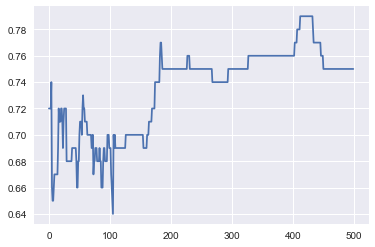

In [17]:

plt.plot(x_plot);
plt.show()

<h2> Question 19 </h2>

In [18]:
print("max accuracy is:")
print(max_accuracy)
print("best lambda is:")
print(max_lambda)

max accuracy is:
0.79
best lambda is:
4.12


<h2> Question 20 </h2>


Heat Map - Reward Function 2


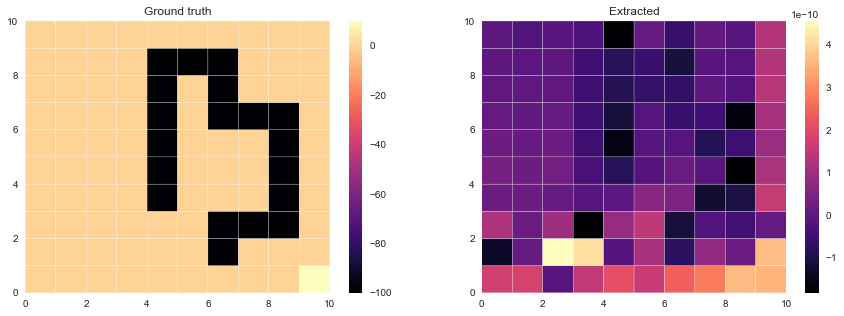

In [19]:

Rmax=1

# x=irl(state_num, action_num, probability_matrix, optimum_policy, discount, Rmax, 0.09)
# current_reward=x['x'][:state_num]
# current_reward=np.reshape(current_reward,(10,10))
# current_reward=np.transpose(current_reward)
# print(sns.heatmap(reward_1))
# print(sns.heatmap(current_reward))


print("\nHeat Map - Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(reward_2), edgecolors = 'white', cmap = 'magma')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
plt.pcolor(np.flipud(max_reward), edgecolors = 'white', cmap = 'magma')
plt.colorbar()
plt.show()




<h2> Question 21 </h2>

Heat map of Optimal State Values for Reward Function 2


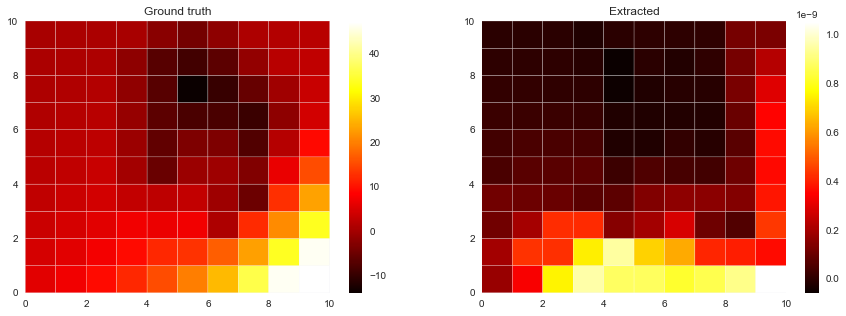

In [20]:
actual_value = value_iteration_value(reward_2, state_space, action_set, discount)
policy_value = value_iteration_value(max_reward, state_space, action_set, discount)

print("Heat map of Optimal State Values for Reward Function 2")
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(nrows=1, ncols=2)

plt.subplot(1,2,1)
plt.title("Ground truth")
plt.pcolor(np.flipud(actual_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Extracted")
#optimal_state_values_extracted_r1 = get_optimal_state_value_fn(extracted_reward_fn_1, S, A, gamma, 0.01, state_space, w)
plt.pcolor(np.flipud(policy_value), edgecolors = 'white', cmap = 'hot')
plt.colorbar()
plt.show()




<h2> Question 23 </h2>

In [21]:
print("Optimal policy - Ground truth vs Extracted - Reward Function 2")

arrows = [u'\u2191', u'\u2190',u'\u2193',u'\u2192']
arrow_matrix = np.array(policy_computed, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(policy_computed[i][j])
        arrow_matrix[i][j] = arrows[index]

        

arrow1_matrix = np.array(actual_policy, dtype=object)
# print arrows
for i in range(0, 10):
    for j in range(0, 10):
        index = int(actual_policy[i][j])
        arrow1_matrix[i][j] = arrows[index]
        

multi_table([pd.DataFrame(arrow1_matrix), pd.DataFrame(arrow_matrix)])



Optimal policy - Ground truth vs Extracted - Reward Function 2


,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,↓
3,↓,↓,↓,←,←,↓,↓,↑,→,↓
4,↓,↓,↓,←,←,↓,↓,↓,→,↓
5,↓,↓,↓,←,←,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,↓,↓,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,↓,↓,↓,↓,↓,↓
9,→,→,→,→,→,→,→,→,→,→


In [22]:
count =0;
for i in range(10):
    for j in range(10):
        if(policy_computed[i][j]==actual_policy[i][j]):
            count+=1;
accuracy=count/100.0;
print(accuracy)

0.75


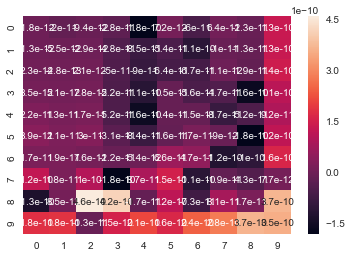

[[-1.81733161e-12 -1.99202545e-11 -9.41939763e-12 -2.78705197e-11
  -1.82441688e-10  7.22902766e-12 -6.01349426e-11  6.41648023e-12
  -1.29503179e-11  1.31760047e-10]
 [-1.25697840e-12 -5.50822693e-12 -2.91150889e-12 -4.75085484e-11
  -8.50900592e-11 -5.39043858e-11 -1.09123022e-10 -1.01251623e-11
  -1.31887807e-11  1.30519662e-10]
 [ 2.28356772e-12 -4.79055355e-13  2.06928391e-12 -4.95460904e-11
  -8.95434467e-11 -6.38847106e-11 -6.66089278e-11 -1.14006280e-12
  -1.91065552e-11  1.39661084e-10]
 [ 8.54467166e-12  5.09328118e-12  7.81262581e-12 -5.20829419e-11
  -1.14148539e-10 -1.53091041e-11 -5.62486525e-11 -4.71015886e-11
  -1.63559744e-10  1.09610720e-10]
 [ 2.22689970e-11  1.29495675e-11  1.70947537e-11 -5.23929682e-11
  -1.59626881e-10 -1.42479254e-11 -1.49309818e-11 -8.69416687e-11
  -5.20158485e-11  9.24982147e-11]
 [ 3.91552084e-11  2.13854585e-11  2.96100742e-11 -3.10617688e-11
  -8.37937289e-11 -1.55507551e-11  1.67713608e-11 -8.95893818e-12
  -1.80978162e-10  1.18703628e-10

In [23]:
ax1 = sns.heatmap(max_reward, annot=True)
plt.show()
print (max_reward)